### **Business Understanding**

- Scenario
    - CMS compiles claims data for Medicare and Medicaid patients across a variety of categories and years. This includes Inpatient and Outpatient claims, Master Beneficiary Summary Files, and many other files. Indicators from this data source have been computed by personnel in CDC's Division for Heart Disease and Stroke Prevention (DHDSP).

The system is designed to integrate multiple indicators from many data sources to provide a comprehensive picture of the public health burden of CVDs and associated risk factors in the United States. The data are organized by location (national and state) and indicator. The data can be plotted as trends and stratified by sex and race/ethnicity.
Goal
•To develop an automated procedure for categorizing the public health burden of various cardiovascular diseases in the United States. The target categories for classification are:
    •	Heart Failure
    •	Coronary Heart Disease
    •	Stroke
    •	Major Cardiovascular Disease
    •	Diseases of the Heart (Heart Disease)
    •	Acute Myocardial Infarction (Heart Attack)

This procedure will ensure accurate and consistent classification of data related to these cardiovascular diseases.

#### **Import modules**

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

#### **Read Data**

In [16]:
df = pd.read_csv('heart_disease_data.csv')

In [17]:
df.head()

,Year,LocationAbbr,LocationDesc,DataSource,PriorityArea1,PriorityArea2,PriorityArea3,PriorityArea4,Category,Topic,...,Break_Out_Category,Break_Out,CategoryId,TopicId,IndicatorID,Data_Value_TypeID,BreakOutCategoryId,BreakOutId,LocationID,GeoLocation
0,2006,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Heart Failure,...,Race,Other,C1,T5,MD501,Crude,BOC04,RAC07,59,NaN
1,2005,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Heart Failure,...,Race,Other,C1,T5,MD501,Crude,BOC04,RAC07,59,NaN
2,2007,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Coronary Heart Disease,...,Age,65+,C1,T4,MD301,Crude,BOC03,AGE06,59,NaN
3,2008,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Coronary Heart Disease,...,Gender,Female,C1,T4,MD301,Crude,BOC02,GEN02,59,NaN
4,2004,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Heart Failure,...,Overall,Overall,C1,T5,MD501,Crude,BOC01,OVR01,59,NaN


In [18]:
df.tail()

,Year,LocationAbbr,LocationDesc,DataSource,PriorityArea1,PriorityArea2,PriorityArea3,PriorityArea4,Category,Topic,...,Break_Out_Category,Break_Out,CategoryId,TopicId,IndicatorID,Data_Value_TypeID,BreakOutCategoryId,BreakOutId,LocationID,GeoLocation
42635,2012,CO,Colorado,Medicare,Million Hearts,NaN,NaN,NaN,Cardiovascular Diseases,Stroke,...,Gender,Male,C1,T6,MD601,Crude,BOC02,GEN01,8,"(38.843840757000464, -106.13361092099967)"
42636,2010,MI,Michigan,Medicare,Million Hearts,NaN,NaN,NaN,Cardiovascular Diseases,Stroke,...,Gender,Female,C1,T6,MD601,Crude,BOC02,GEN02,26,"(44.6613195430005, -84.71439026999968)"
42637,2012,ME,Maine,Medicare,Million Hearts,NaN,NaN,NaN,Cardiovascular Diseases,Stroke,...,Race,Hispanic,C1,T6,MD601,Crude,BOC04,RAC04,23,"(45.254228894000505, -68.98503133599962)"
42638,2013,ID,Idaho,Medicare,Million Hearts,NaN,NaN,NaN,Cardiovascular Diseases,Stroke,...,Race,Non-Hispanic White,C1,T6,MD601,Crude,BOC04,RAC01,16,"(43.682630005000476, -114.3637300419997)"
42639,2012,IA,Iowa,Medicare,Million Hearts,NaN,NaN,NaN,Cardiovascular Diseases,Stroke,...,Gender,Male,C1,T6,MD601,Crude,BOC02,GEN01,19,"(42.46940091300047, -93.81649055599968)"


### **Data Understanding**

##### **Data Dimension(n_rows X n_columns)**

In [19]:
df.shape

(42640, 29)

##### **How many Elements?**

In [20]:
df.size

1236560

<Axes: >

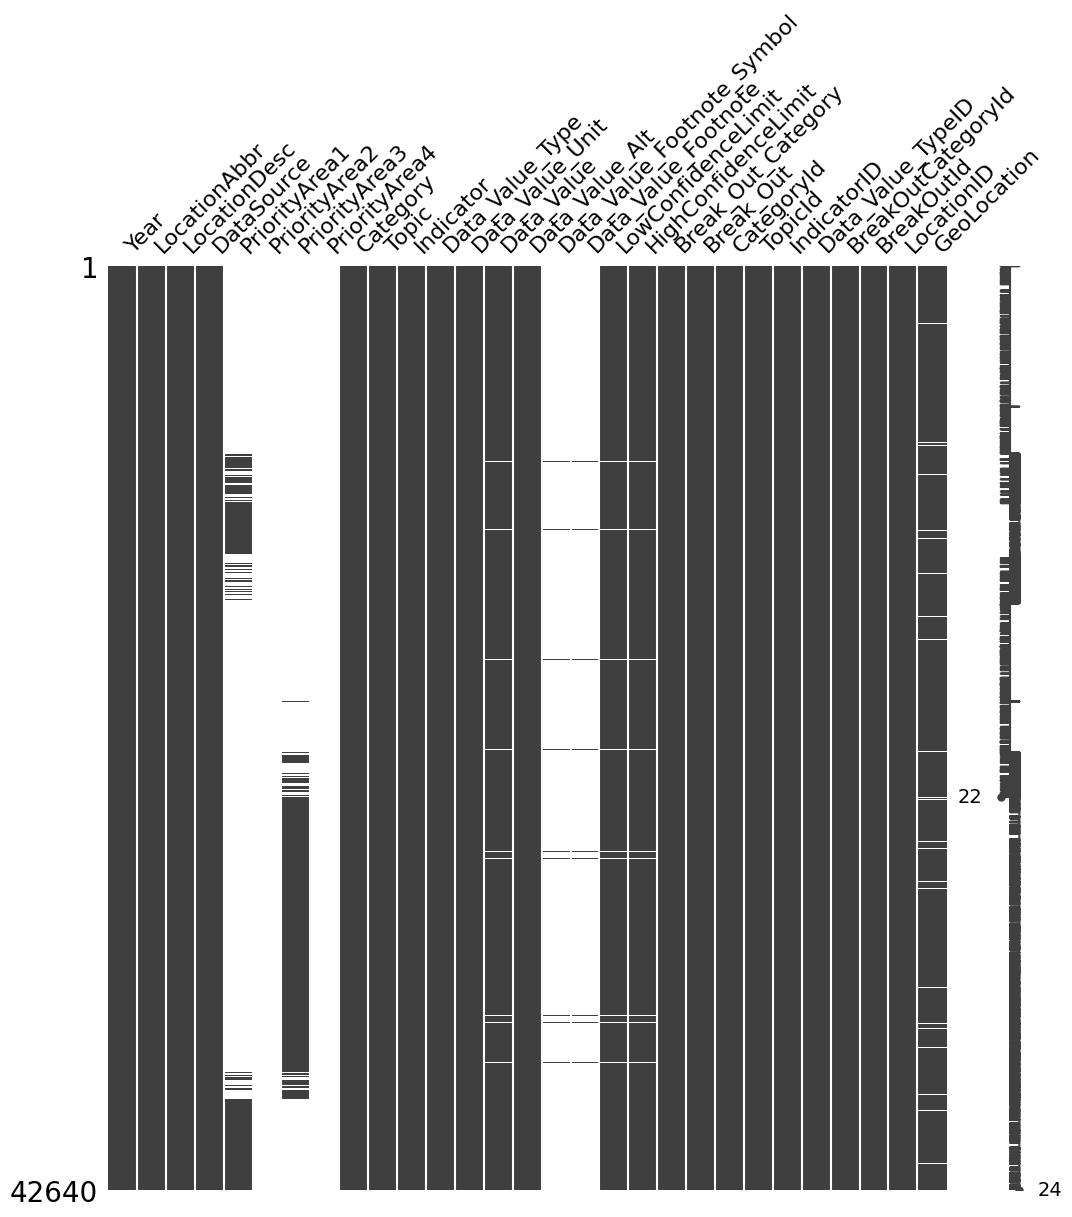

In [21]:
msno.matrix(df,figsize=(12,12))

##### **Attributes**

In [22]:
print(df.columns.tolist())

['Year', 'LocationAbbr', 'LocationDesc', 'DataSource', 'PriorityArea1', 'PriorityArea2', 'PriorityArea3', 'PriorityArea4', 'Category', 'Topic', 'Indicator', 'Data_Value_Type', 'Data_Value_Unit', 'Data_Value', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'LowConfidenceLimit', 'HighConfidenceLimit', 'Break_Out_Category', 'Break_Out', 'CategoryId', 'TopicId', 'IndicatorID', 'Data_Value_TypeID', 'BreakOutCategoryId', 'BreakOutId', 'LocationID', 'GeoLocation']


| Column Name               | Description                                                  |
|---------------------------|--------------------------------------------------------------|
| Year                      | The year the data was collected.                             |
| LocationAbbr              | Abbreviation of the location.                                |
| LocationDesc              | Full description of the location.                            |
| DataSource                | The source of the data (e.g., Survey, Registry).             |
| PriorityArea1 to PriorityArea4 | Priority areas related to the data.                        |
| Category                  | The general category of the data (e.g., Health).             |
| Topic                     | Specific topic within the category (e.g., Cardiovascular).   |
| Indicator                 | The specific indicator being measured (e.g., Heart Disease Mortality). |
| Data_Value_Type           | The type of data value (e.g., Rate, Percentage).             |
| Data_Value_Unit           | The unit of the data value (e.g., Per 100,000).              |
| Data_Value                | The value of the data.                                       |
| Data_Value_Alt            | An alternative value for the data.                           |
| Data_Value_Footnote_Symbol| Footnote symbol for additional information.                 |
| Data_Value_Footnote       | Footnote text providing additional information.              |
| LowConfidenceLimit        | The lower bound of the confidence interval.                  |
| HighConfidenceLimit       | The upper bound of the confidence interval.                  |
| Break_Out_Category        | The category for breaking out data (e.g., Gender).           |
| Break_Out                 | The specific break out within the category (e.g., Male, Female). |
| CategoryId                | Identifier for the category.                                  |
| TopicId                   | Identifier for the topic.                                    |
| IndicatorID               | Identifier for the indicator.                                 |
| Data_Value_TypeID         | Identifier for the data value type.                          |
| BreakOutCategoryId        | Identifier for the break out category.                       |
| BreakOutId                | Identifier for the break out.                                |
| LocationID                | Identifier for the location.                                 |
| GeoLocation               | Geographic location in POINT (longitude latitude) format.    |


##### **Top 10 Records**

In [23]:
df.head(10)

,Year,LocationAbbr,LocationDesc,DataSource,PriorityArea1,PriorityArea2,PriorityArea3,PriorityArea4,Category,Topic,...,Break_Out_Category,Break_Out,CategoryId,TopicId,IndicatorID,Data_Value_TypeID,BreakOutCategoryId,BreakOutId,LocationID,GeoLocation
0,2006,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Heart Failure,...,Race,Other,C1,T5,MD501,Crude,BOC04,RAC07,59,NaN
1,2005,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Heart Failure,...,Race,Other,C1,T5,MD501,Crude,BOC04,RAC07,59,NaN
2,2007,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Coronary Heart Disease,...,Age,65+,C1,T4,MD301,Crude,BOC03,AGE06,59,NaN
3,2008,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Coronary Heart Disease,...,Gender,Female,C1,T4,MD301,Crude,BOC02,GEN02,59,NaN
4,2004,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Heart Failure,...,Overall,Overall,C1,T5,MD501,Crude,BOC01,OVR01,59,NaN
5,2012,US,United States,Medicare,NaN,NaN,NaN,NaN,Cardiovascular Diseases,Heart Failure,...,Race,Other,C1,T5,MD501,Crude,BOC04,RAC07,59,NaN
6,2005,NY,New York,Medicare,Million Hearts,NaN,NaN,NaN,Cardiovascular Diseases,Stroke,...,Age,65+,C1,T6,MD601,Crude,BOC03,AGE06,36,"(42.82700103200045, -75.54397042699964)"
7,2008,CT,Connecticut,Medicare,Million Hearts,NaN,NaN,NaN,Cardiovascular Diseases,Stroke,...,Age,75+,C1,T6,MD601,Crude,BOC03,AGE08,9,"(41.56266102000046, -72.64984095199964)"
8,2008,ME,Maine,Medicare,Million Hearts,NaN,NaN,NaN,Cardiovascular Diseases,Stroke,...,Race,Other,C1,T6,MD601,Crude,BOC04,RAC07,23,"(45.254228894000505, -68.98503133599962)"
9,2010,OH,Ohio,Medicare,Million Hearts,NaN,NaN,NaN,Cardiovascular Diseases,Stroke,...,Age,75+,C1,T6,MD601,Crude,BOC03,AGE08,39,"(40.06021014100048, -82.40426005599966)"


#### **Get Attribute type**

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42640 entries, 0 to 42639
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        42640 non-null  int64  
 1   LocationAbbr                42640 non-null  object 
 2   LocationDesc                42640 non-null  object 
 3   DataSource                  42640 non-null  object 
 4   PriorityArea1               9360 non-null   object 
 5   PriorityArea2               0 non-null      float64
 6   PriorityArea3               14560 non-null  object 
 7   PriorityArea4               0 non-null      float64
 8   Category                    42640 non-null  object 
 9   Topic                       42640 non-null  object 
 10  Indicator                   42640 non-null  object 
 11  Data_Value_Type             42640 non-null  object 
 12  Data_Value_Unit             42640 non-null  object 
 13  Data_Value                  421

#### **Convert wrong attribute types**

- LocationAbbr
- LocationDesc
- DataSource
- PriorityArea1
- PriorityArea3
- Category
- Topic
- Indicator
- Data_Value_Type
- Data_Value_Unit
- Datol
- Data_Value_Footnote
- Break_Out_Category
- Break_Out
- CategoryId
- TopicId
- IndicatorID
- Data_Value_TypeID
- BreakOutId
- LocationID
- GeoLocation



are categorical attribs

In [25]:
for attribute in df.columns:
    if df[attribute].dtype == object:
        df[attribute] = df[attribute].astype('category')
df['LocationID'] = df['LocationID'].astype('category')
df['Year'] = df['Year'].astype('category')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42640 entries, 0 to 42639
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Year                        42640 non-null  category
 1   LocationAbbr                42640 non-null  category
 2   LocationDesc                42640 non-null  category
 3   DataSource                  42640 non-null  category
 4   PriorityArea1               9360 non-null   category
 5   PriorityArea2               0 non-null      float64 
 6   PriorityArea3               14560 non-null  category
 7   PriorityArea4               0 non-null      float64 
 8   Category                    42640 non-null  category
 9   Topic                       42640 non-null  category
 10  Indicator                   42640 non-null  category
 11  Data_Value_Type             42640 non-null  category
 12  Data_Value_Unit             42640 non-null  category
 13  Data_Value      

#### **Get General Statistics**

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PriorityArea2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PriorityArea4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Data_Value,42111.0,14.780896,13.286487,0.4,4.5,10.7,21.6,333.3
Data_Value_Alt,42640.0,14.572709,13.333826,-2.0,4.4,10.4,21.5,333.3
LowConfidenceLimit,42111.0,12.661509,11.453615,0.0,3.8,8.2,19.6,94.2
HighConfidenceLimit,42111.0,17.074028,17.910274,1.1,5.0,12.7,23.4,710.5


#### PriorityArea2, PriorityArea4 contains None values throughout, also these variables dont serve any purpose in prediction of our target variable.
#### *Let us drop those features.*


In [28]:
df = df[df.columns.difference(
    ['PriorityArea2', 'PriorityArea4'])]

In [29]:
df.describe(include = 'category').T

,count,unique,top,freq
BreakOutCategoryId,42640,4,BOC04,20800
BreakOutId,42640,9,GEN01,5200
Break_Out,42640,9,Female,5200
Break_Out_Category,42640,4,Race,20800
Category,42640,1,Cardiovascular Diseases,42640
CategoryId,42640,1,C1,42640
DataSource,42640,1,Medicare,42640
Data_Value_Footnote,529,1,Statistically unstable estimates not presented...,529
Data_Value_Footnote_Symbol,529,1,~,529
Data_Value_Type,42640,1,Crude,42640


<Axes: >

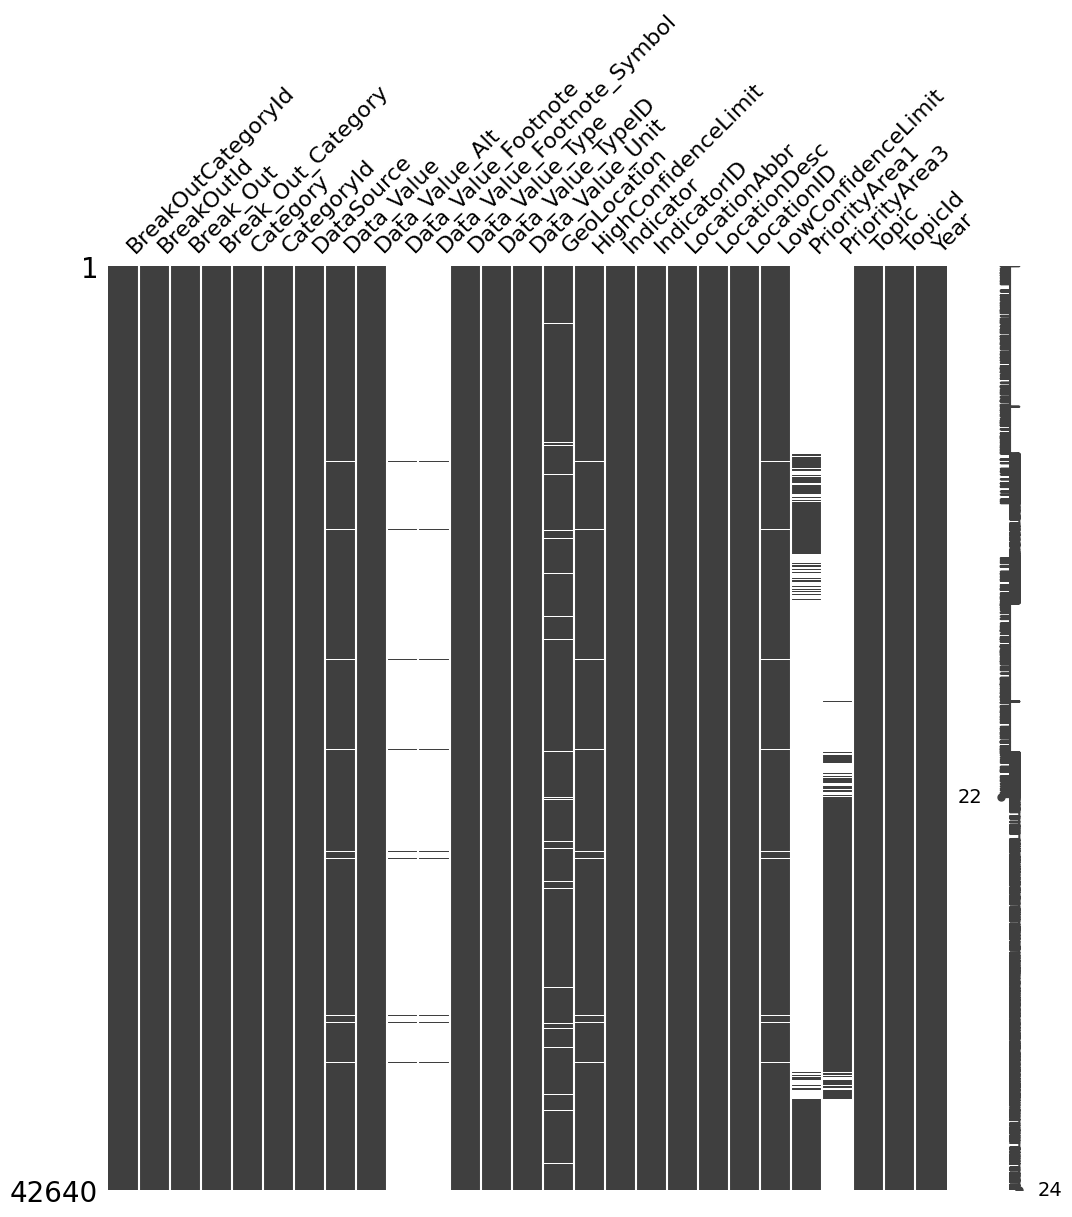

In [30]:
msno.matrix(df,figsize=(12,12))

### **Building Histograms(Numeric Attr)**

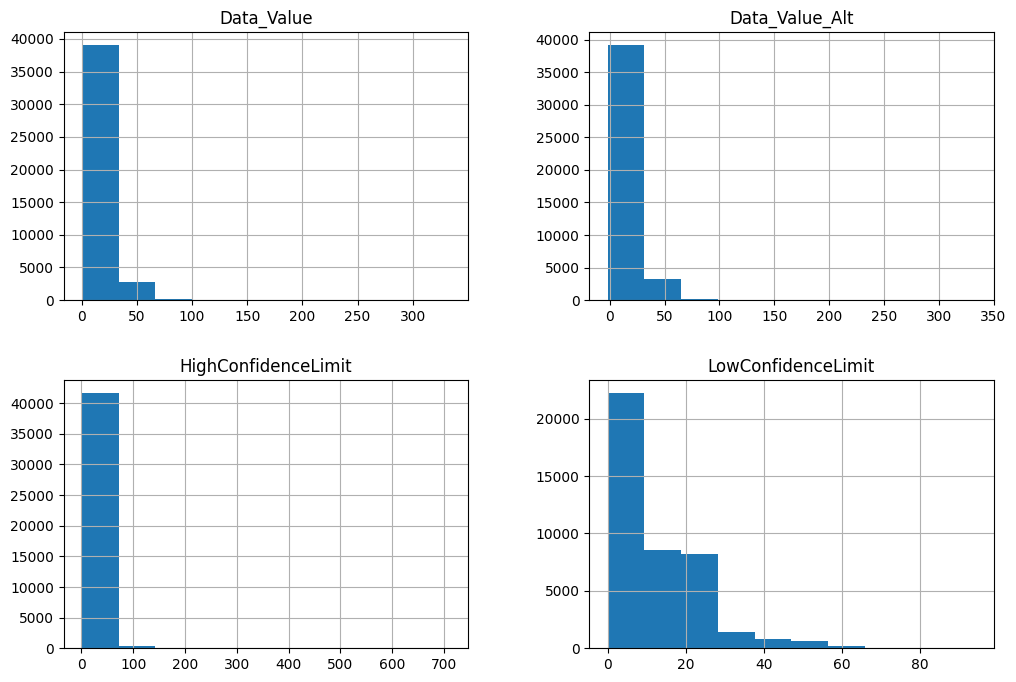

In [168]:
df.hist(figsize = (12, 8))
plt.show()

### **Bar plots for Categorical Attributes**

In [169]:
cat_atr = df.select_dtypes(include='category').columns

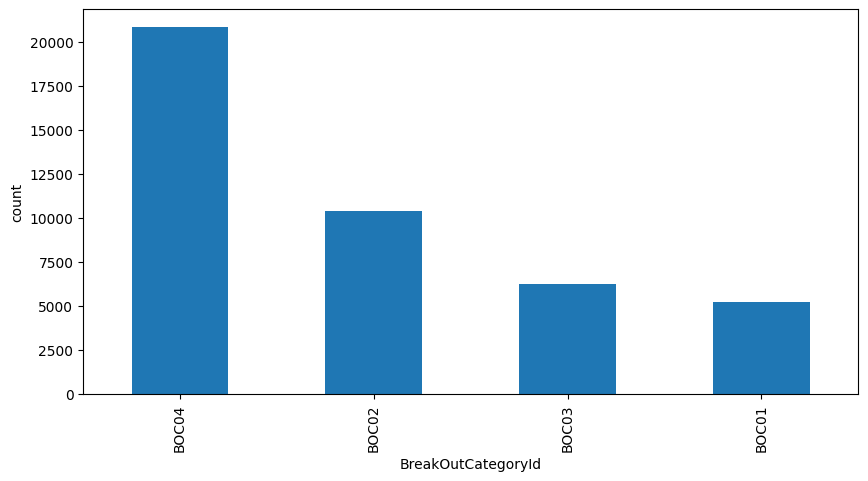

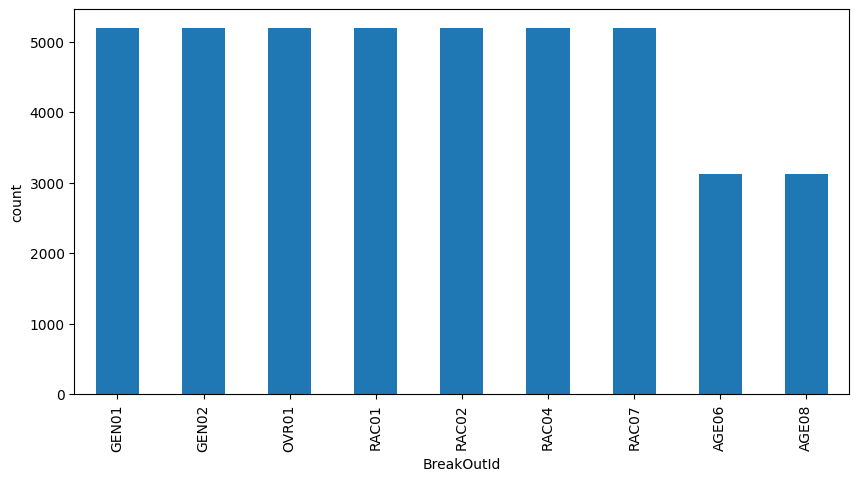

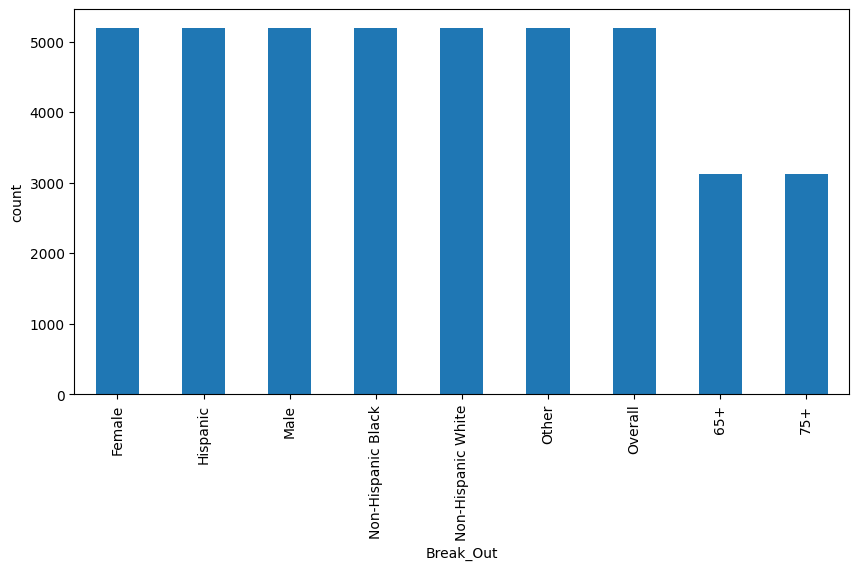

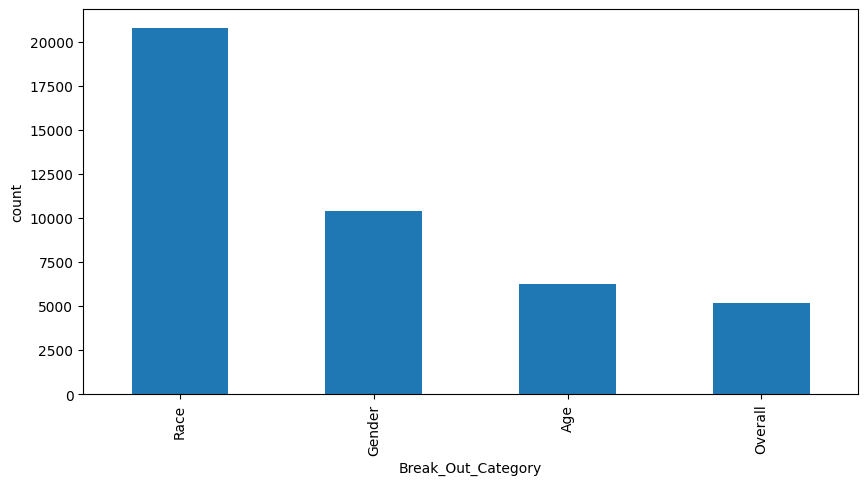

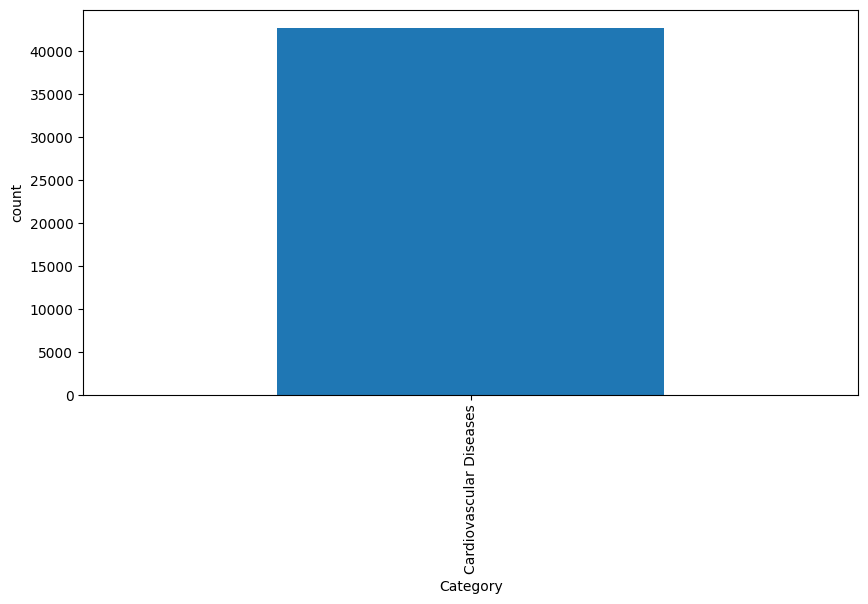

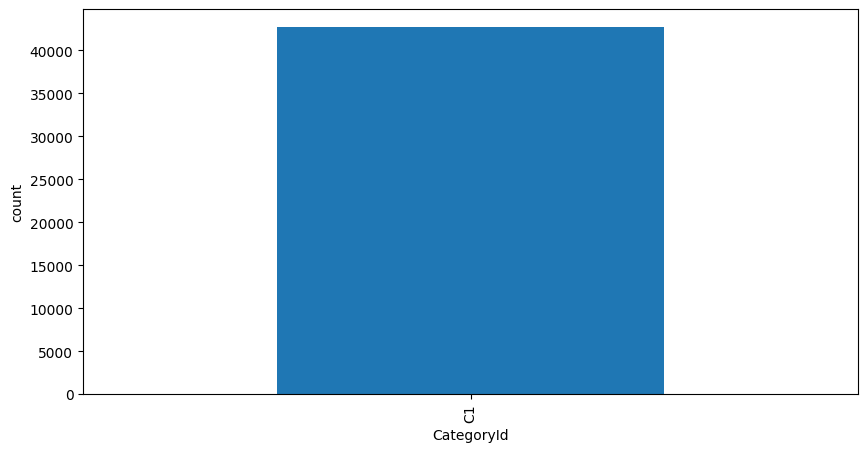

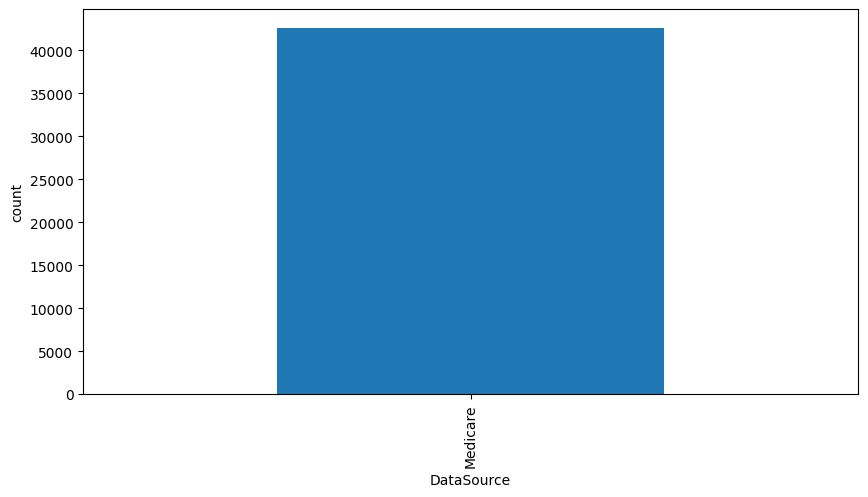

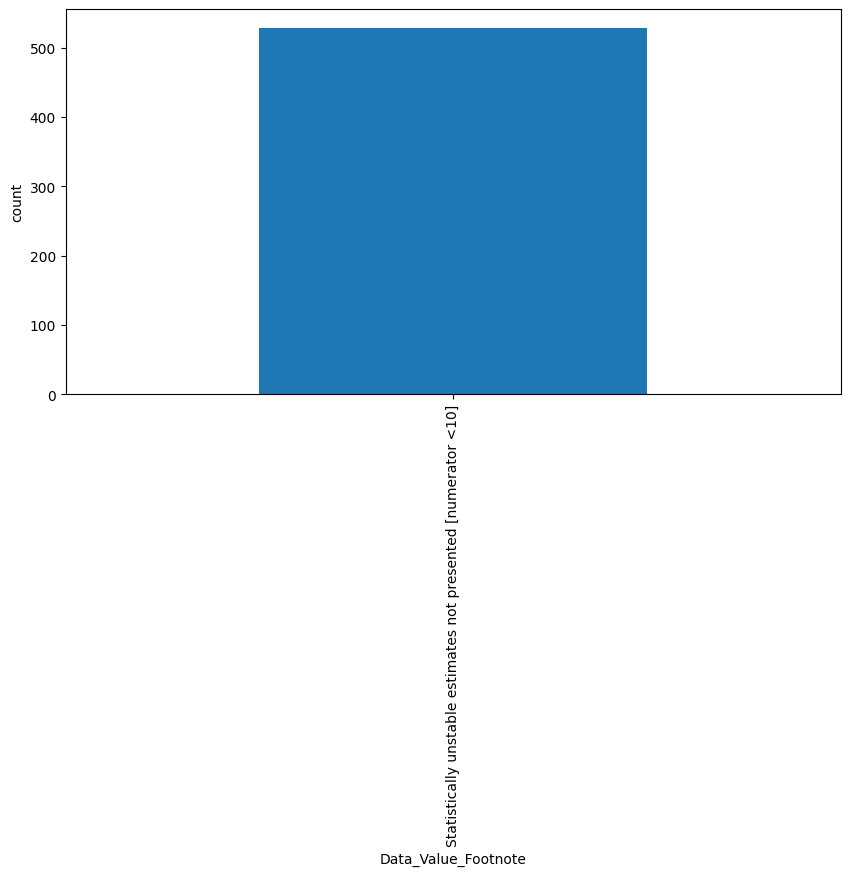

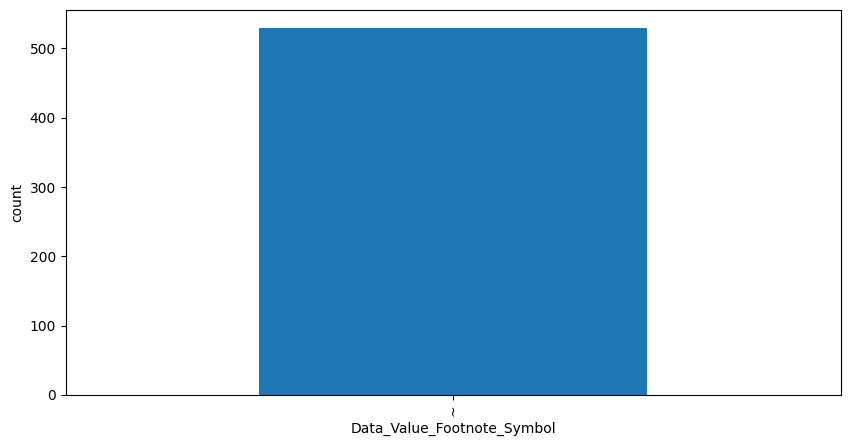

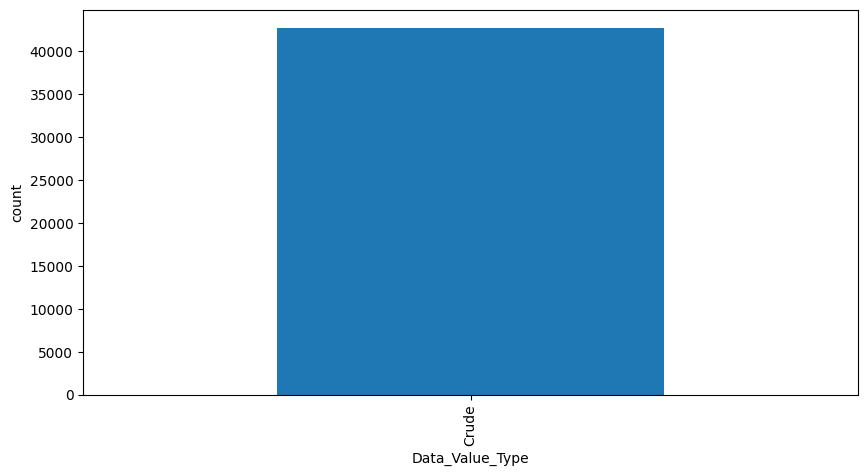

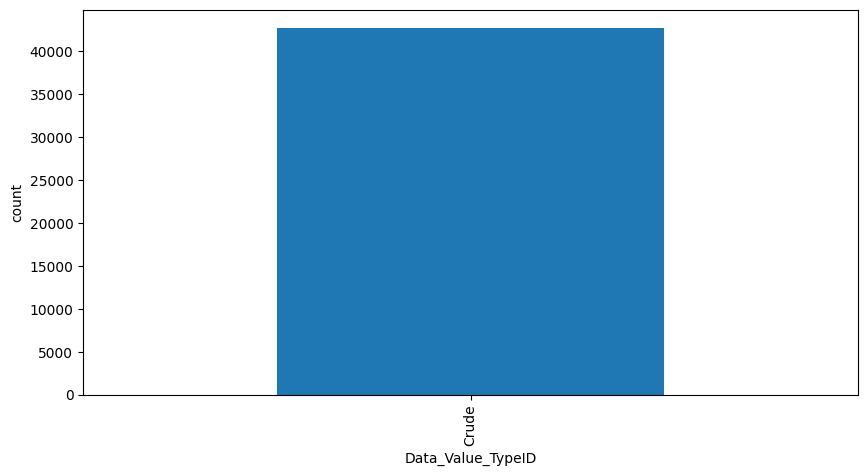

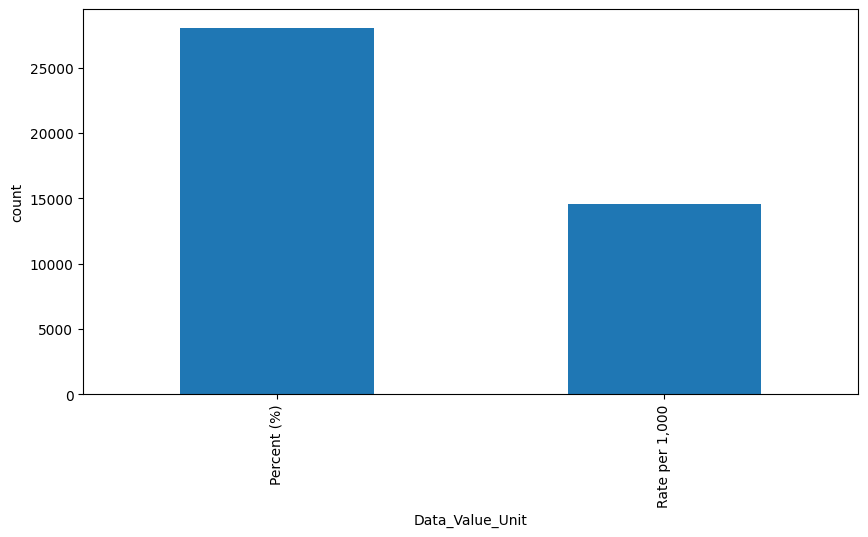

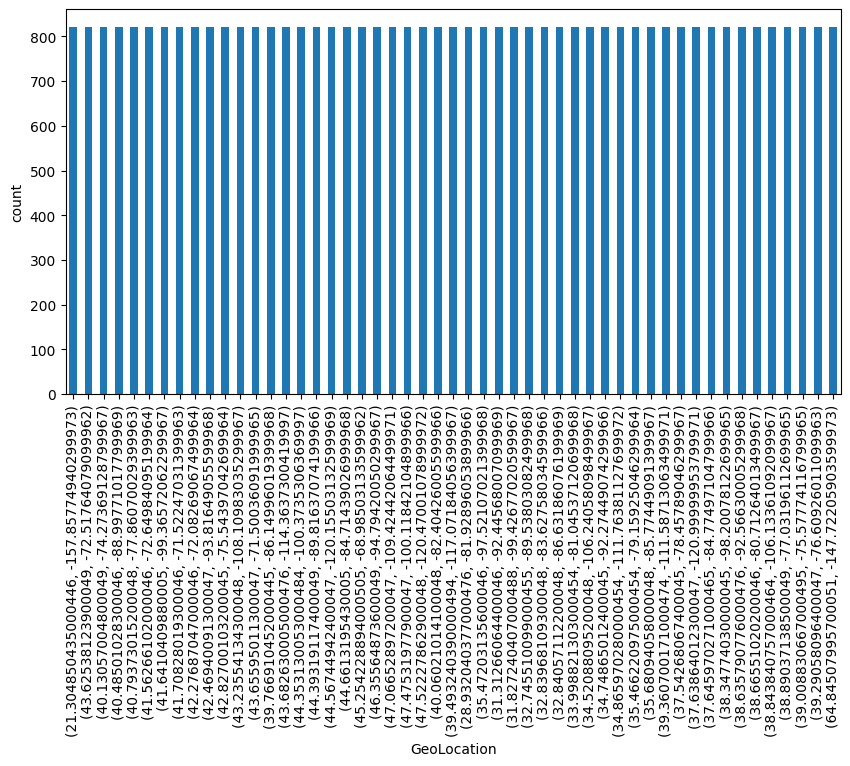

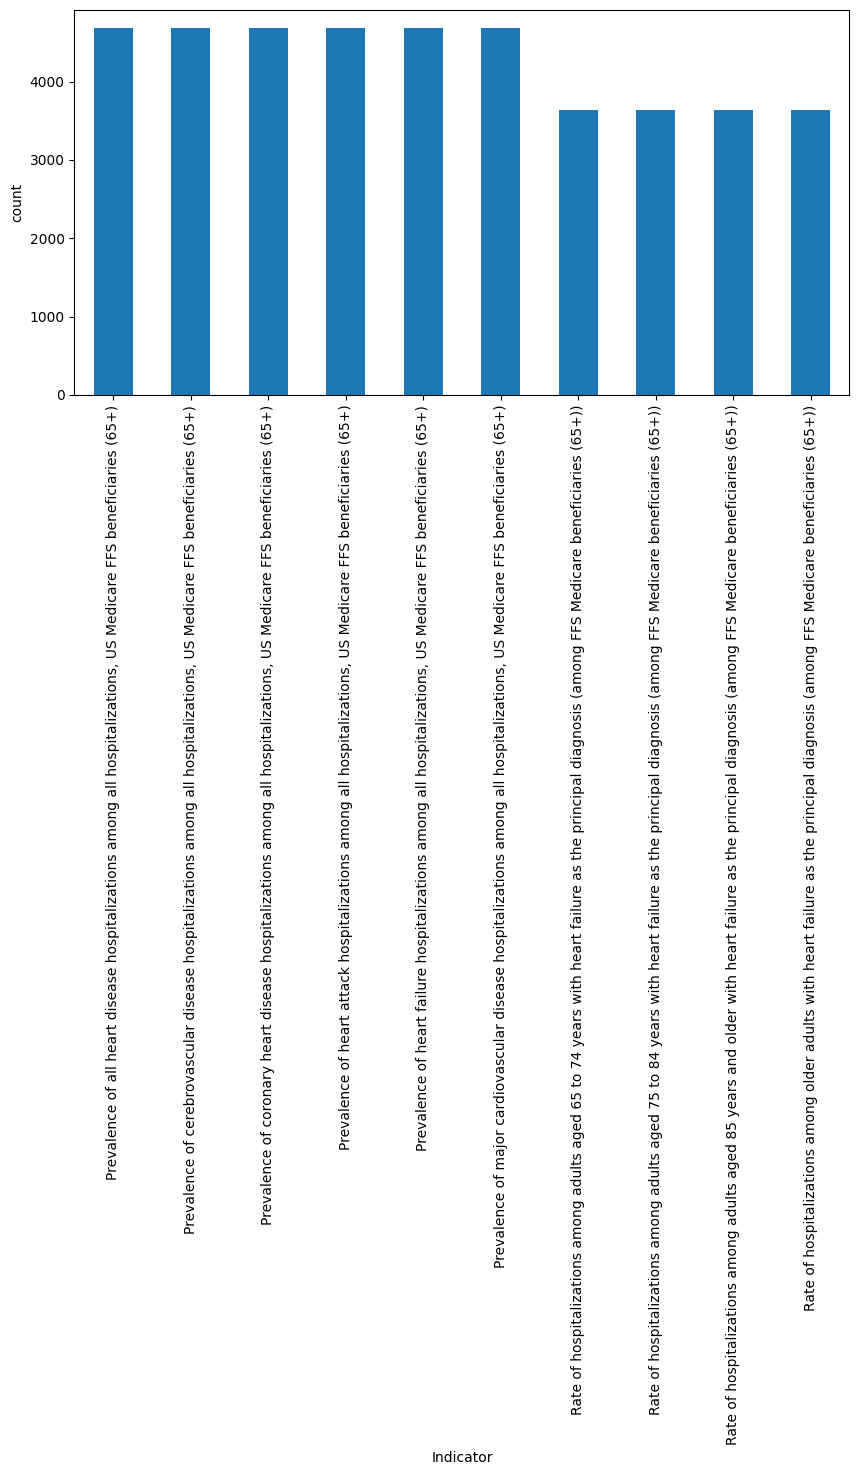

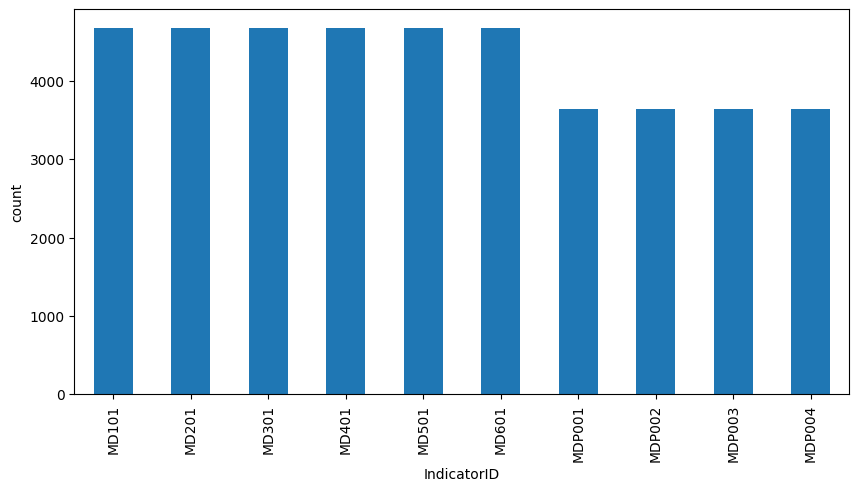

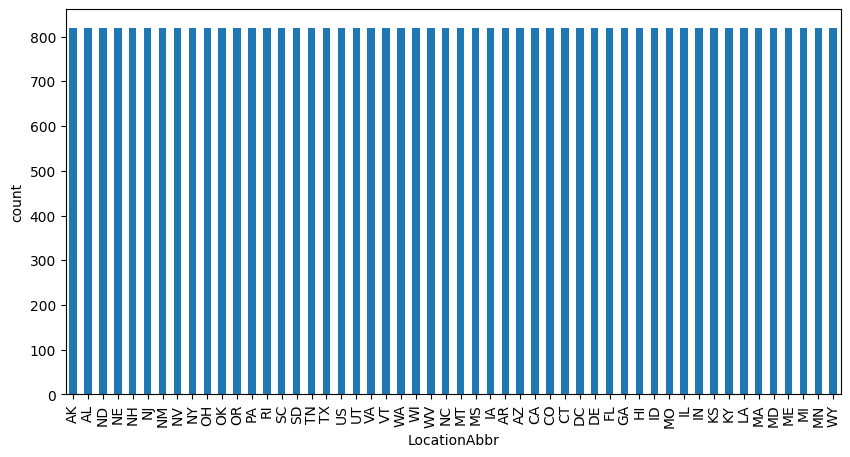

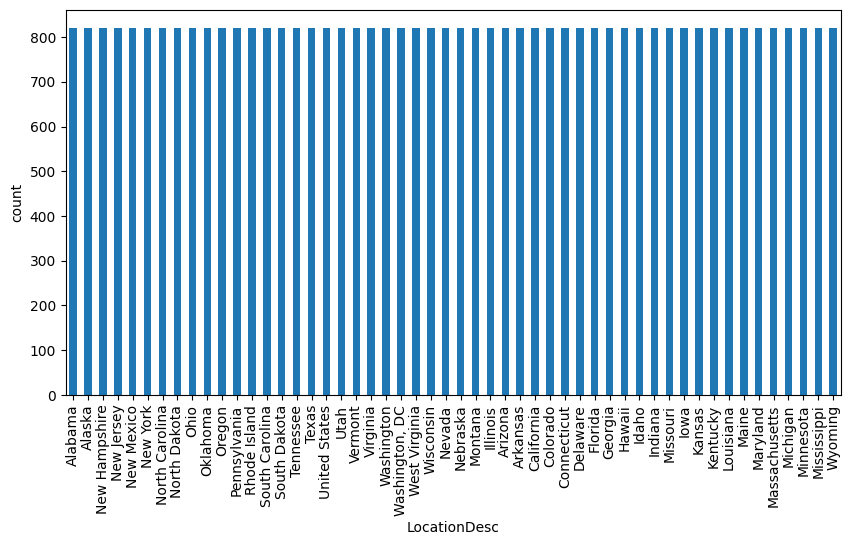

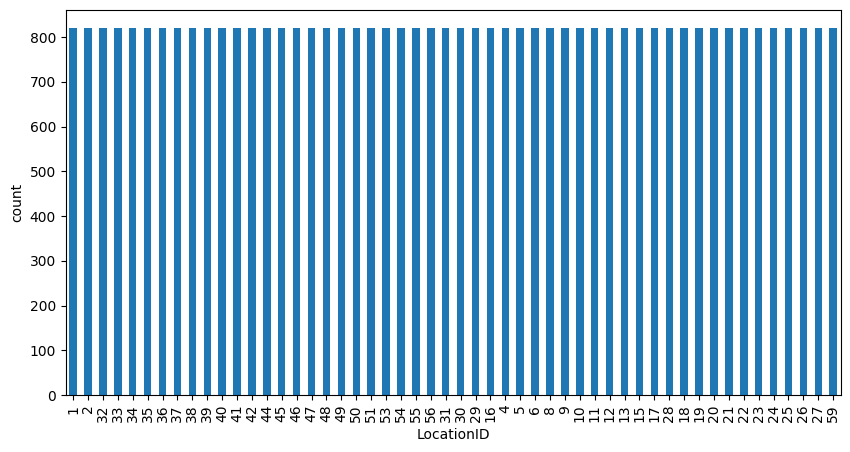

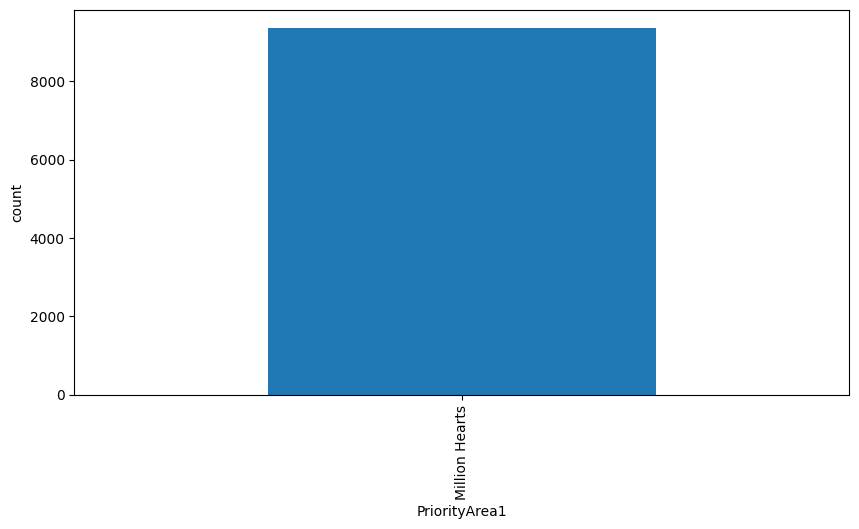

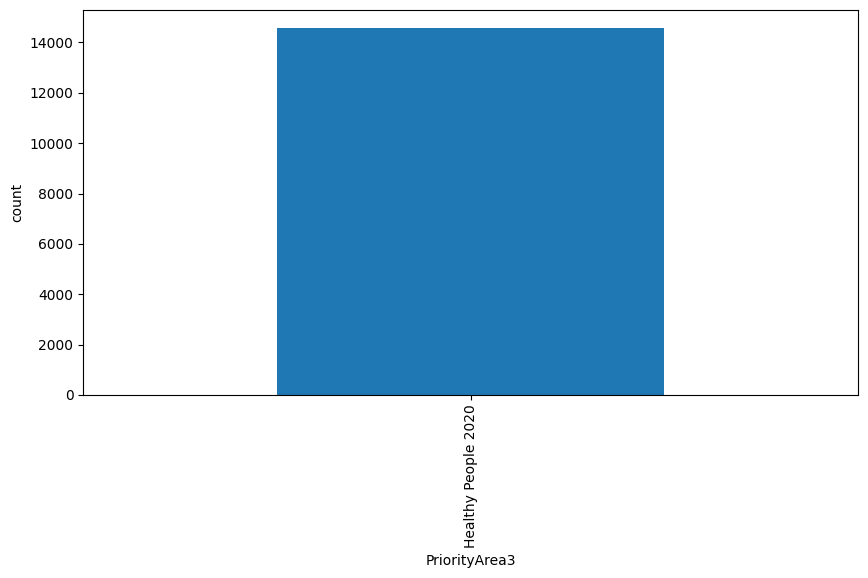

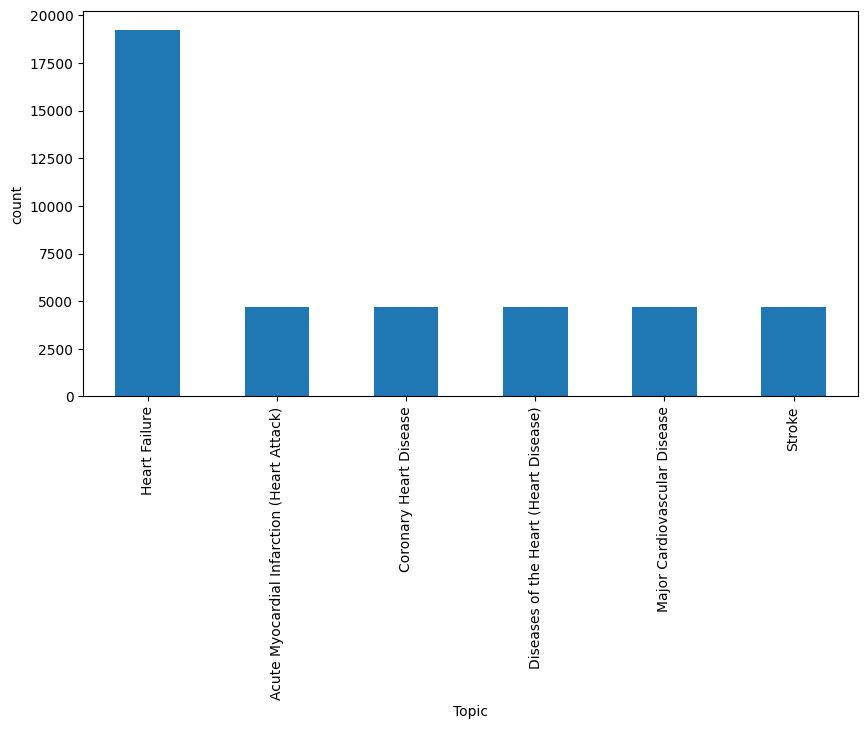

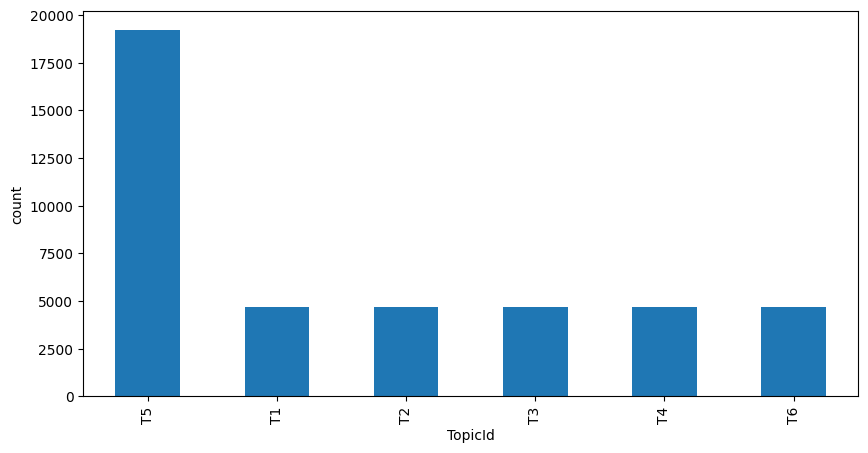

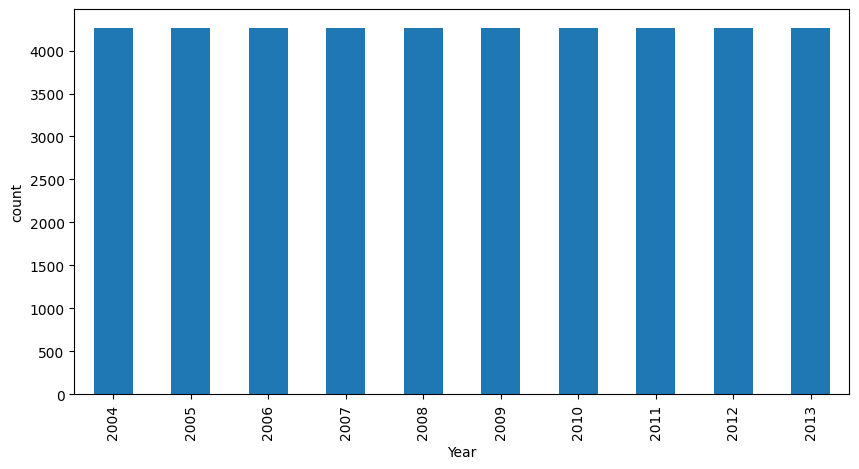

In [170]:
for attribute in cat_atr:
    val = df[attribute].value_counts()
    val.plot(kind = 'bar', figsize = (10, 5))
    plt.ylabel('count')
    plt.xlabel(attribute)
    plt.show()

#### **Histograms and bar plots according to the class attributes**

In [171]:
import seaborn as sb
numericDF = df.select_dtypes(include=[np.number])

#### **Select Numerical columns**


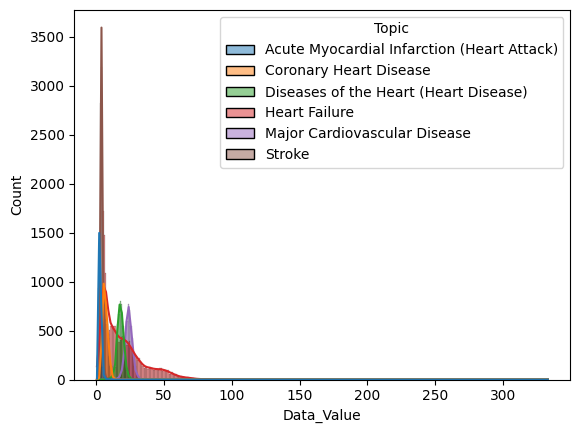

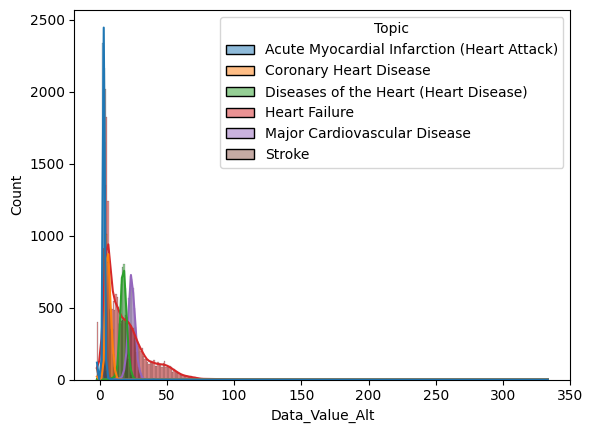

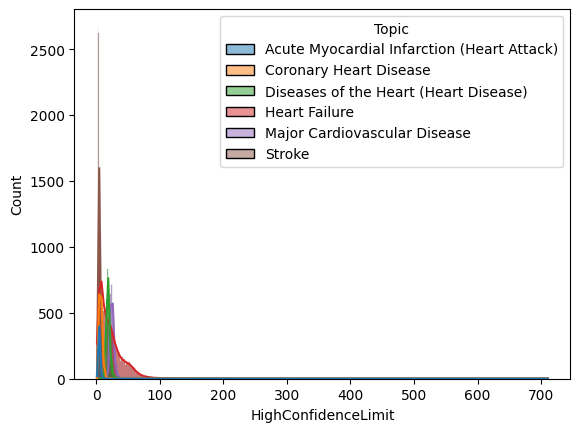

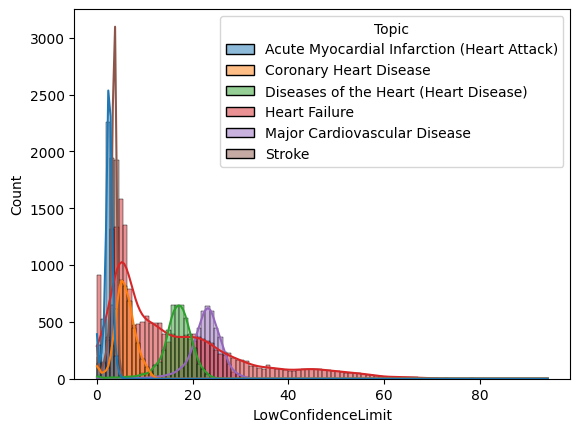

In [172]:
for attribute in numericDF:
    sb.histplot(x = df[attribute], hue = 'Topic', data = df, kde=True)
    plt.show()

#### **Select categorical columns**


In [173]:
cat_atr = df.select_dtypes(include='category').columns
# Exclude the 'Topic' column from the categorical columns
categoricalAttributes = cat_atr.difference(['Topic'])

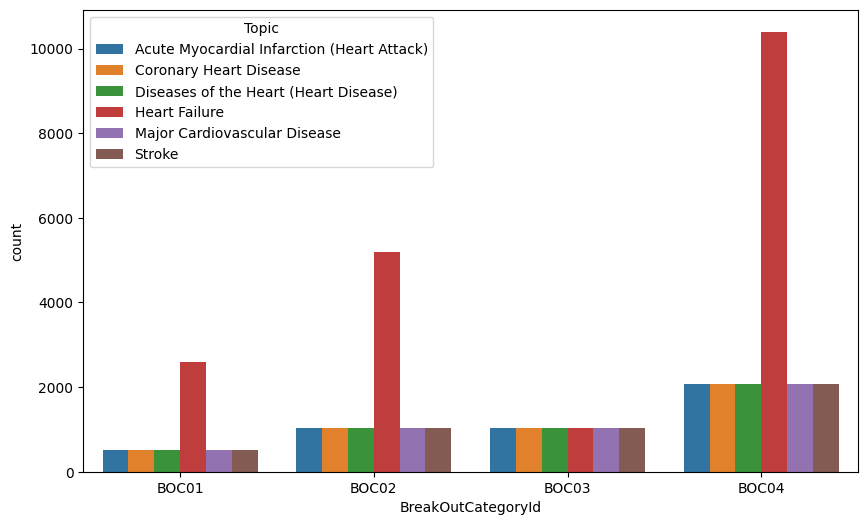

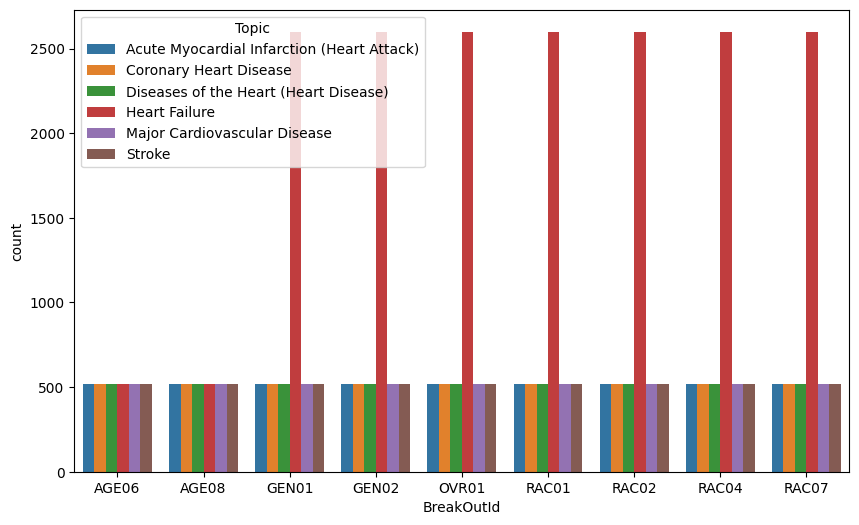

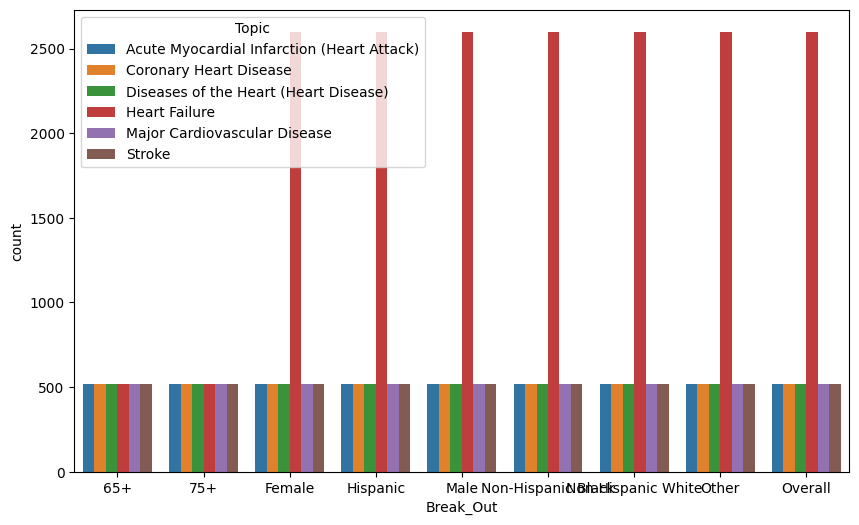

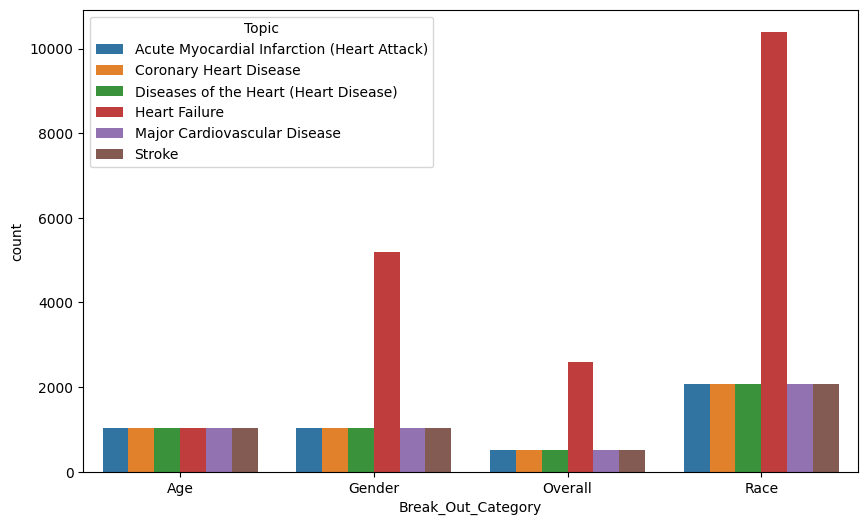

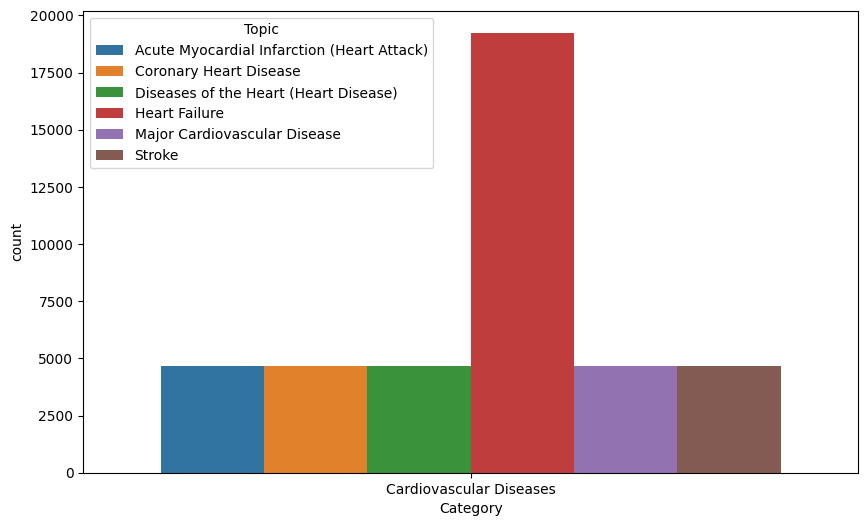

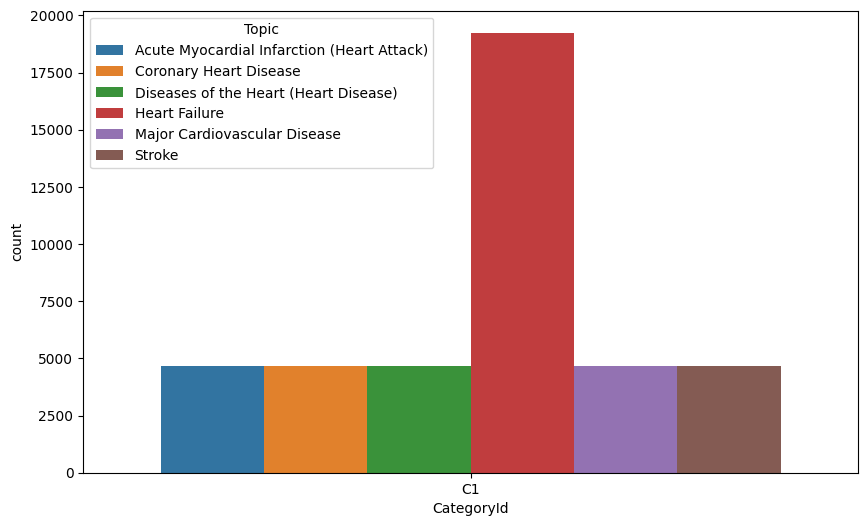

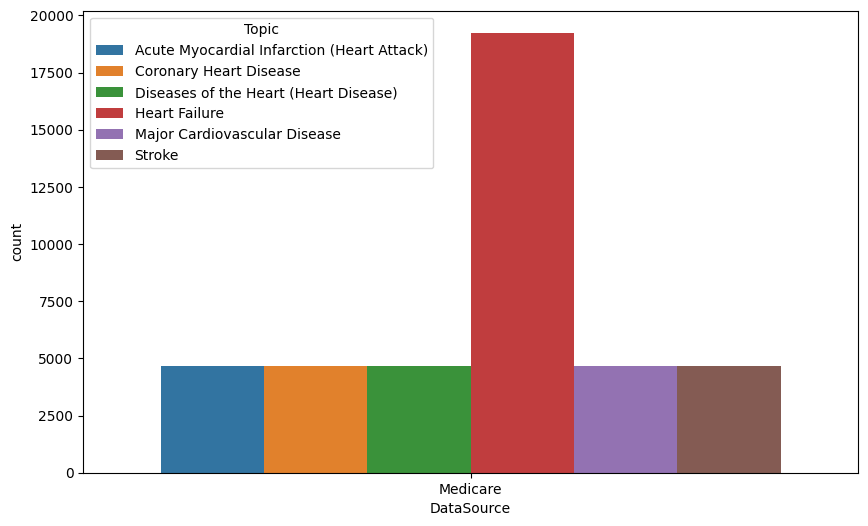

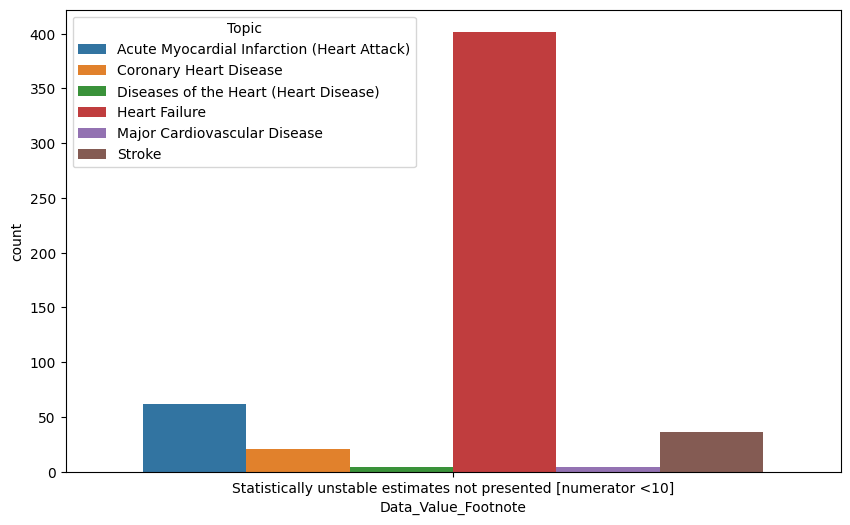

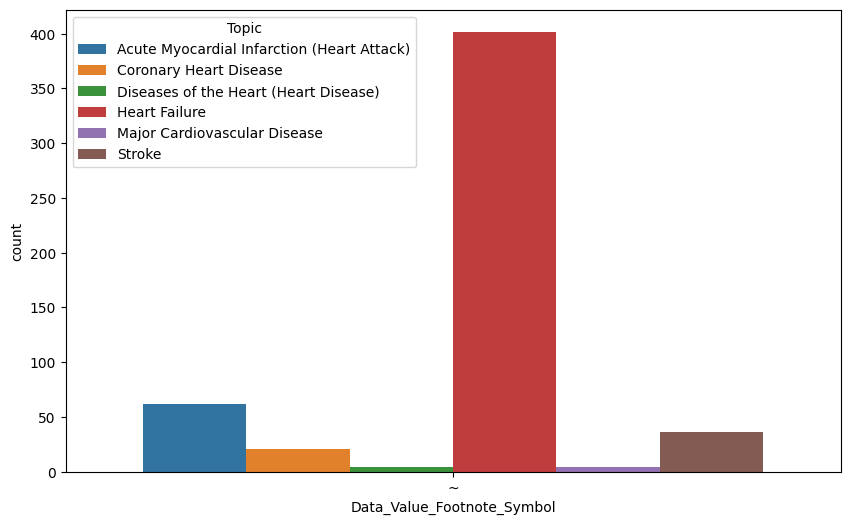

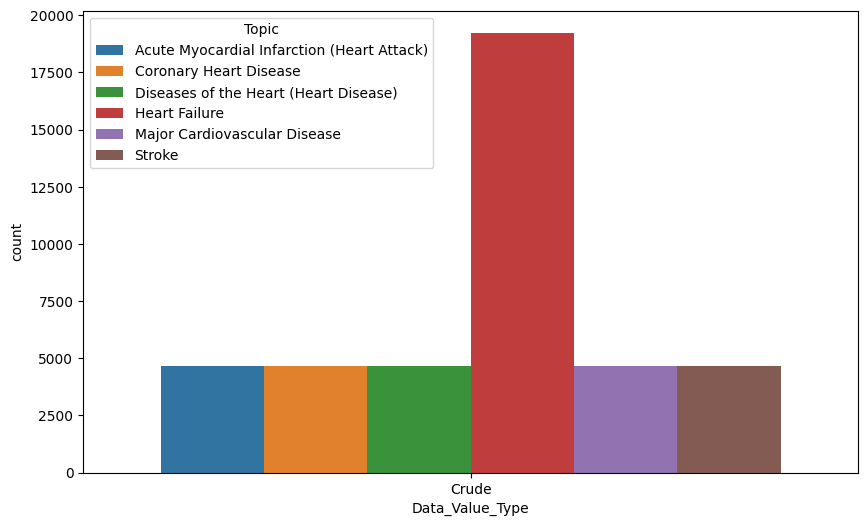

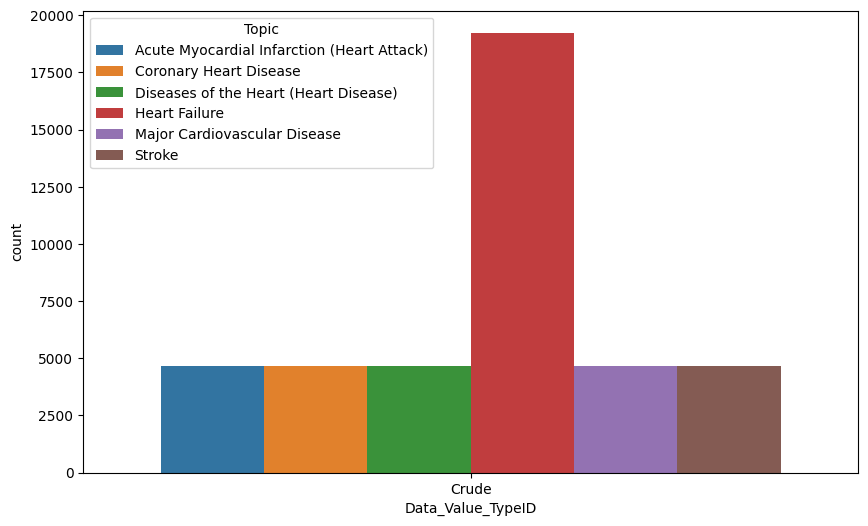

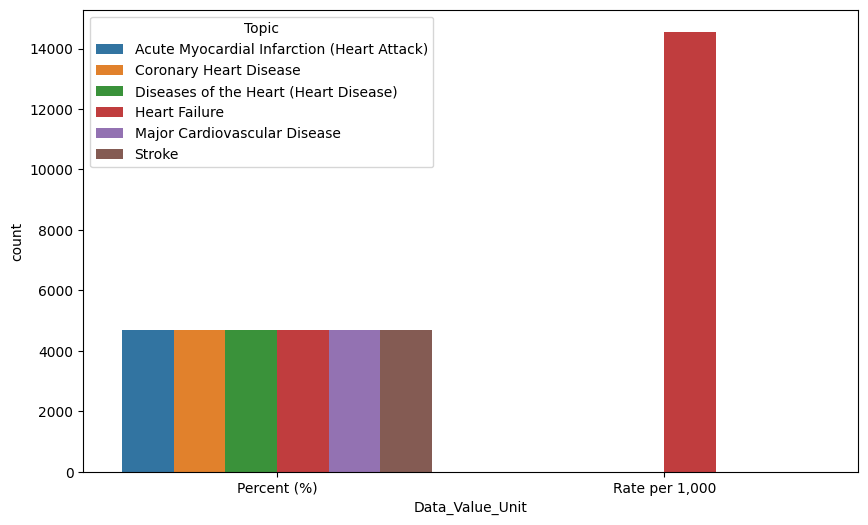

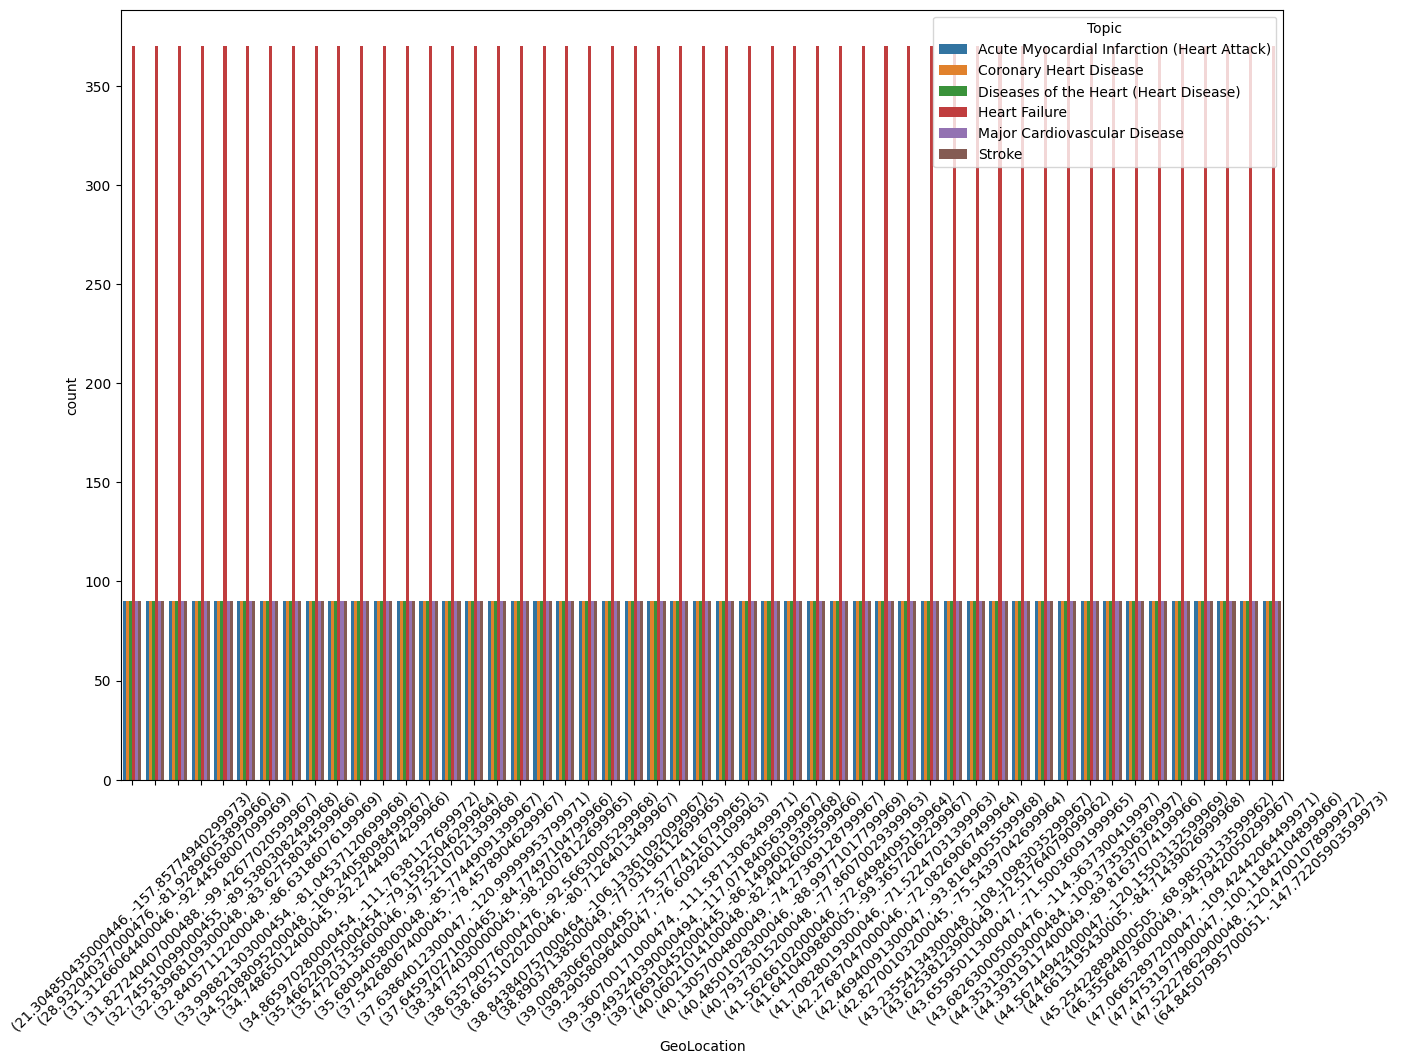

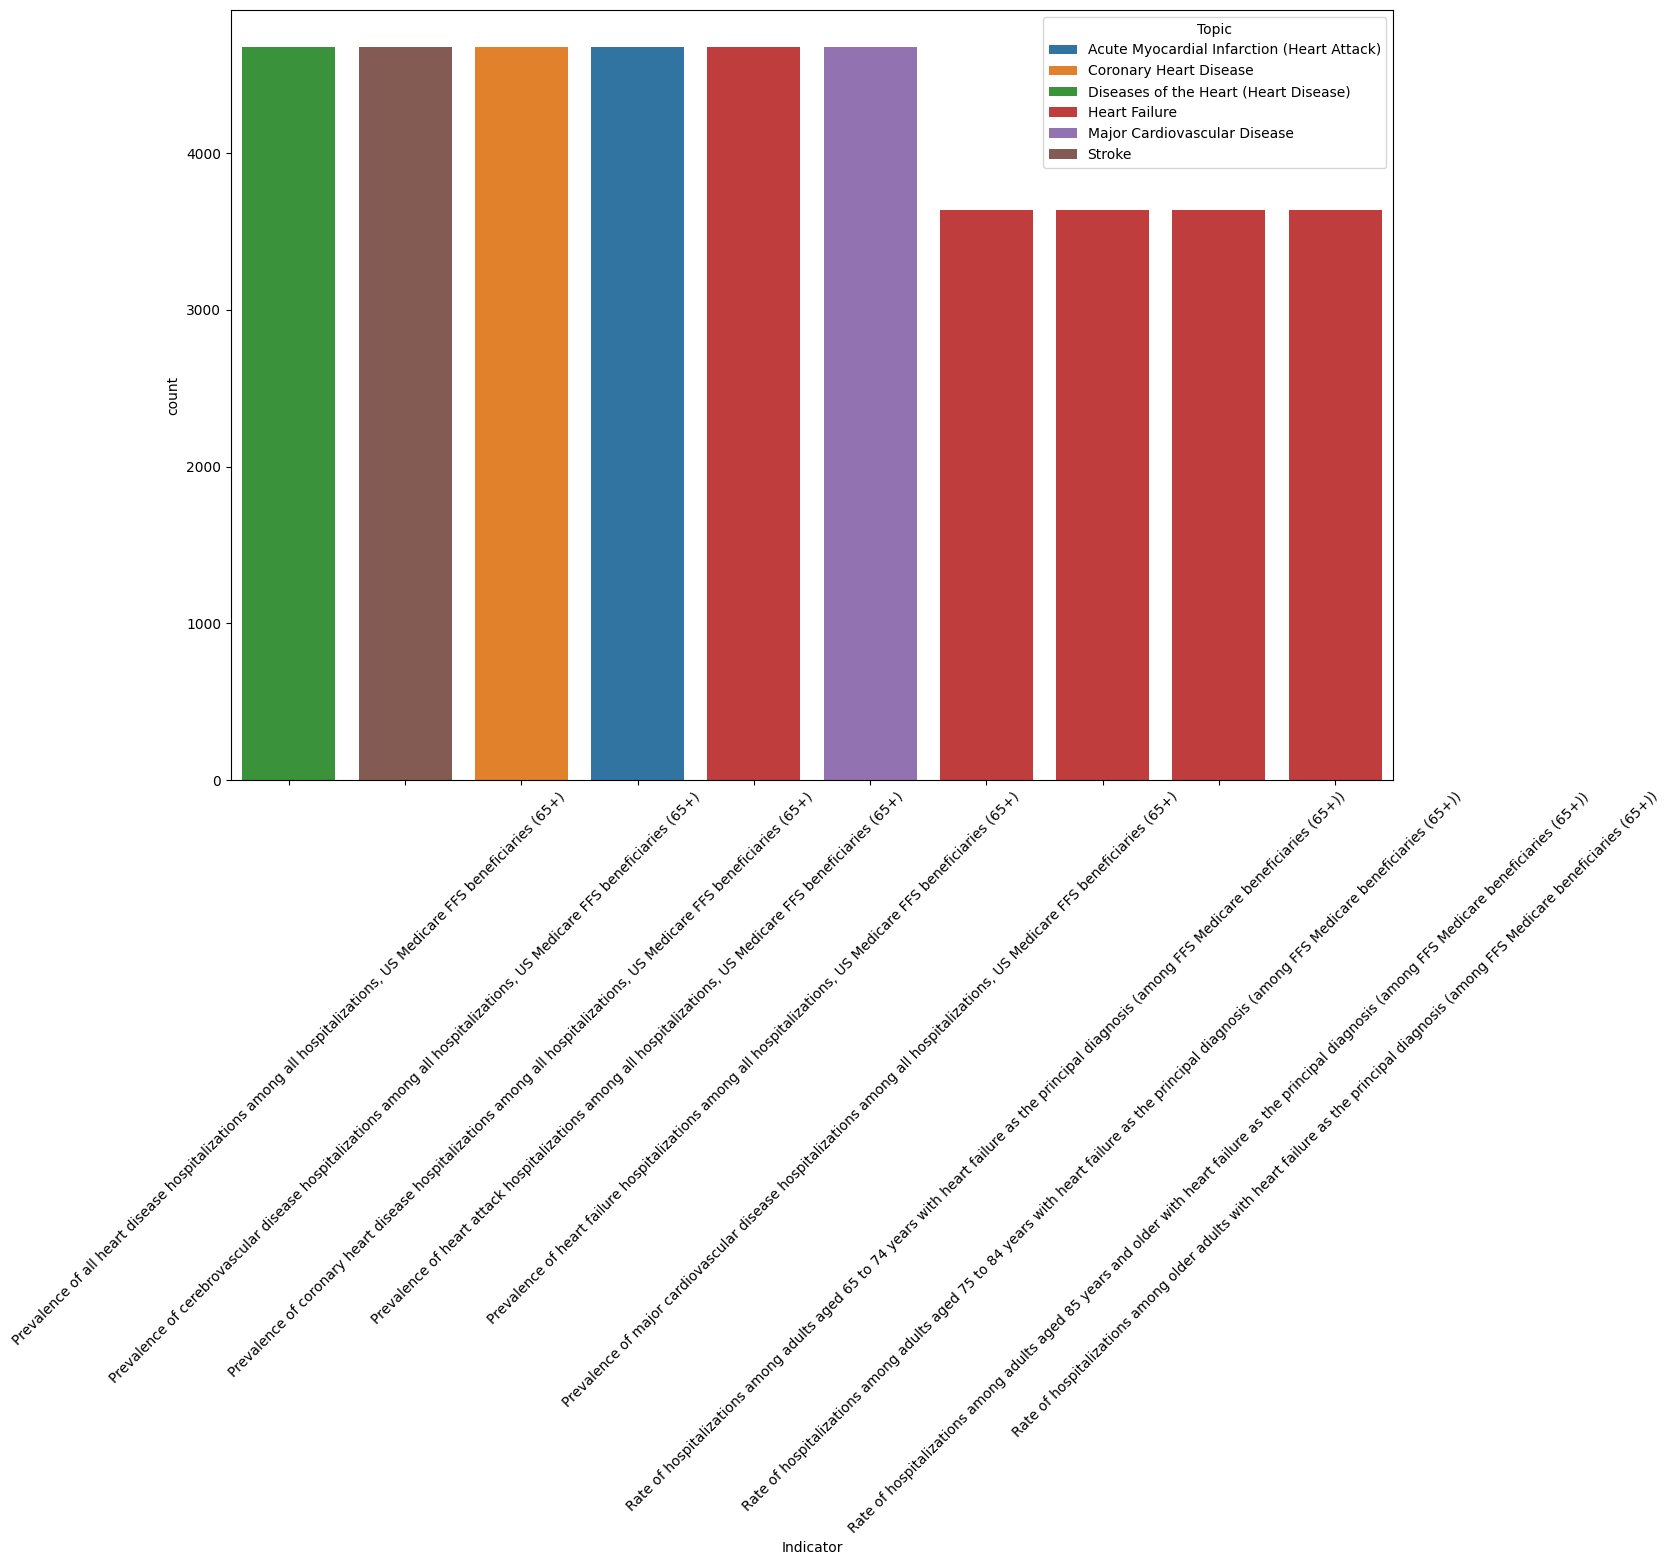

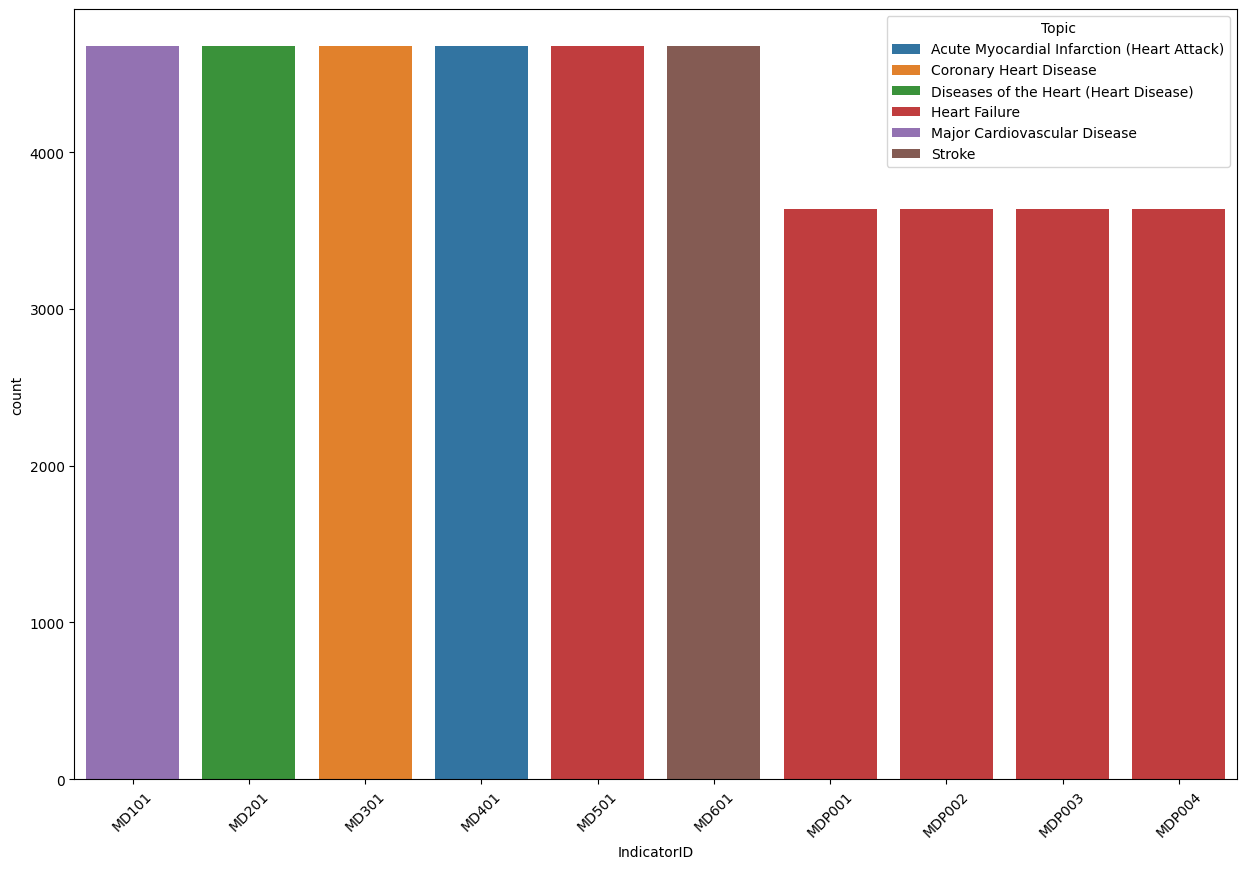

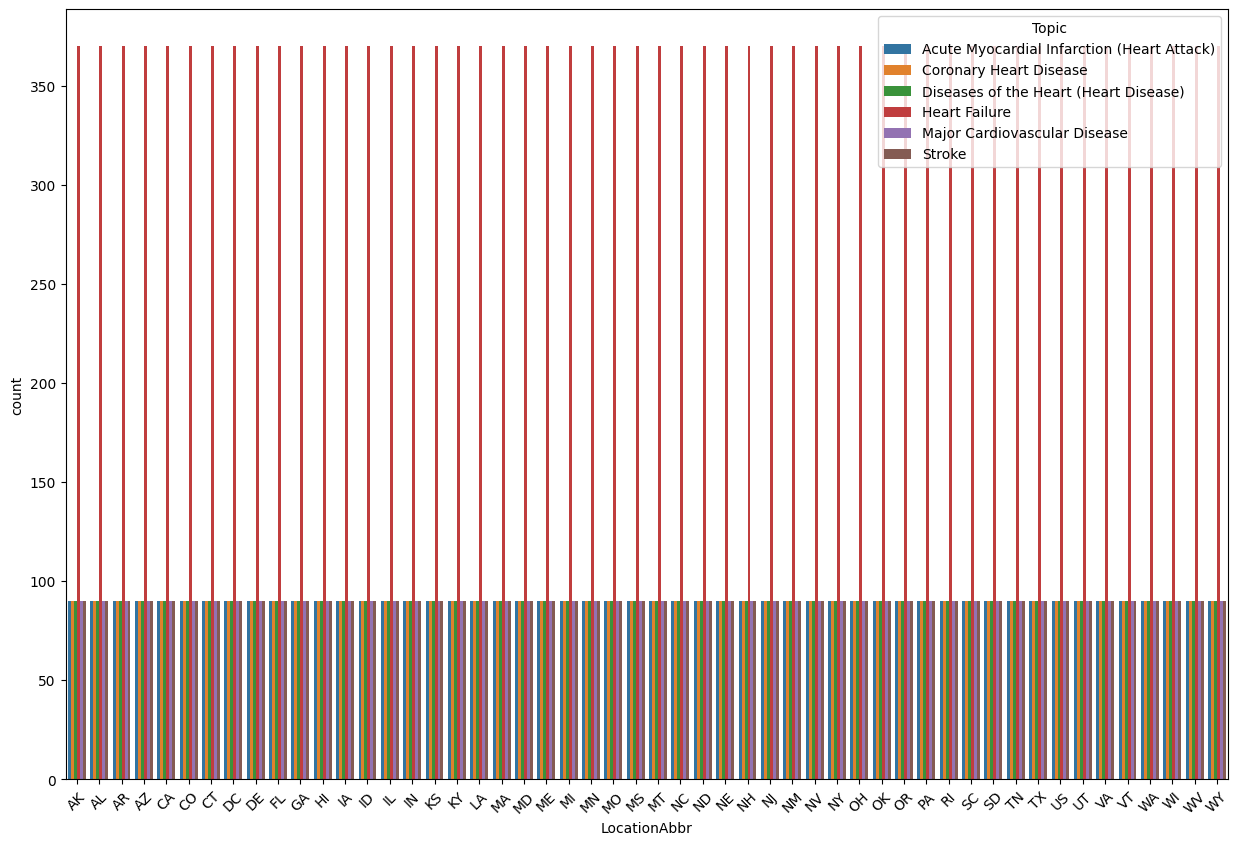

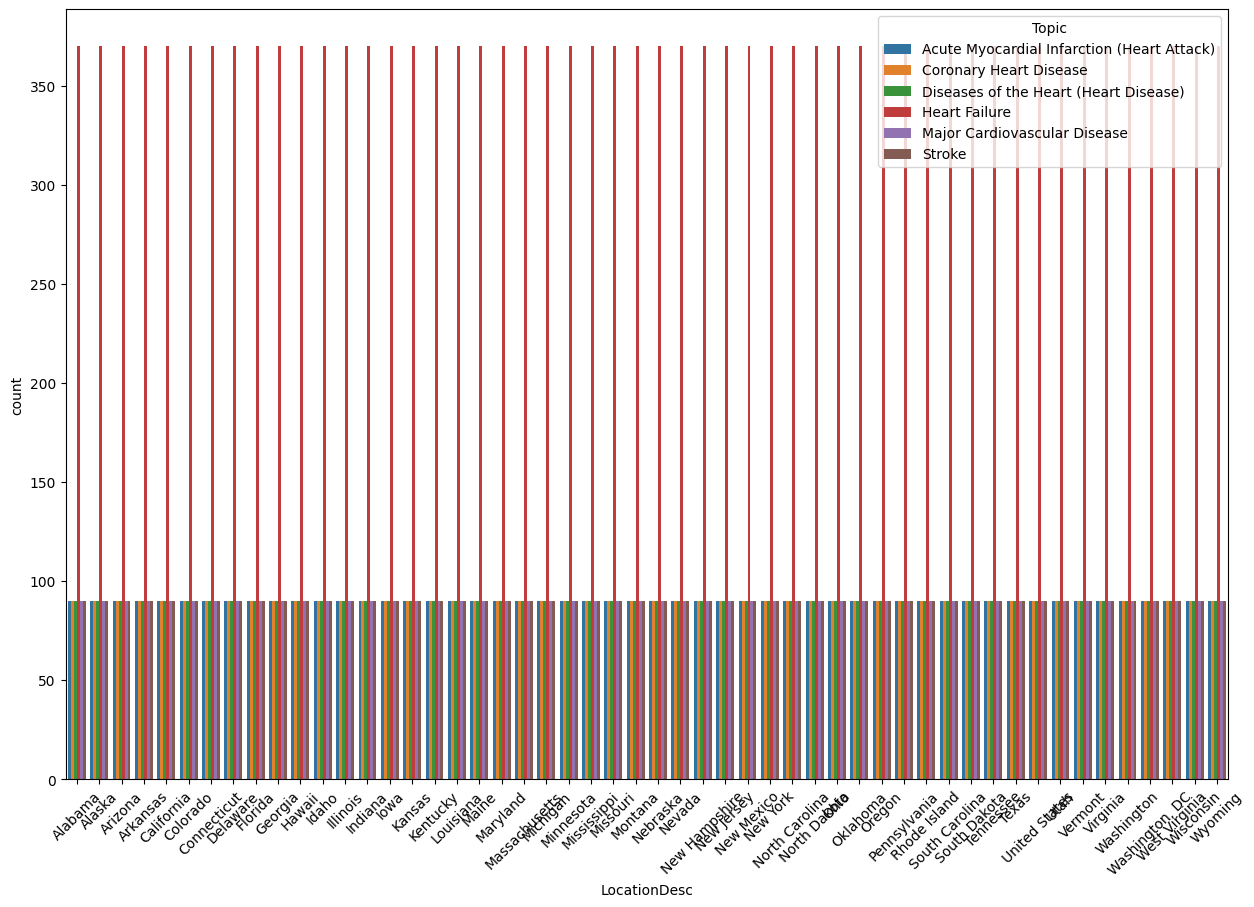

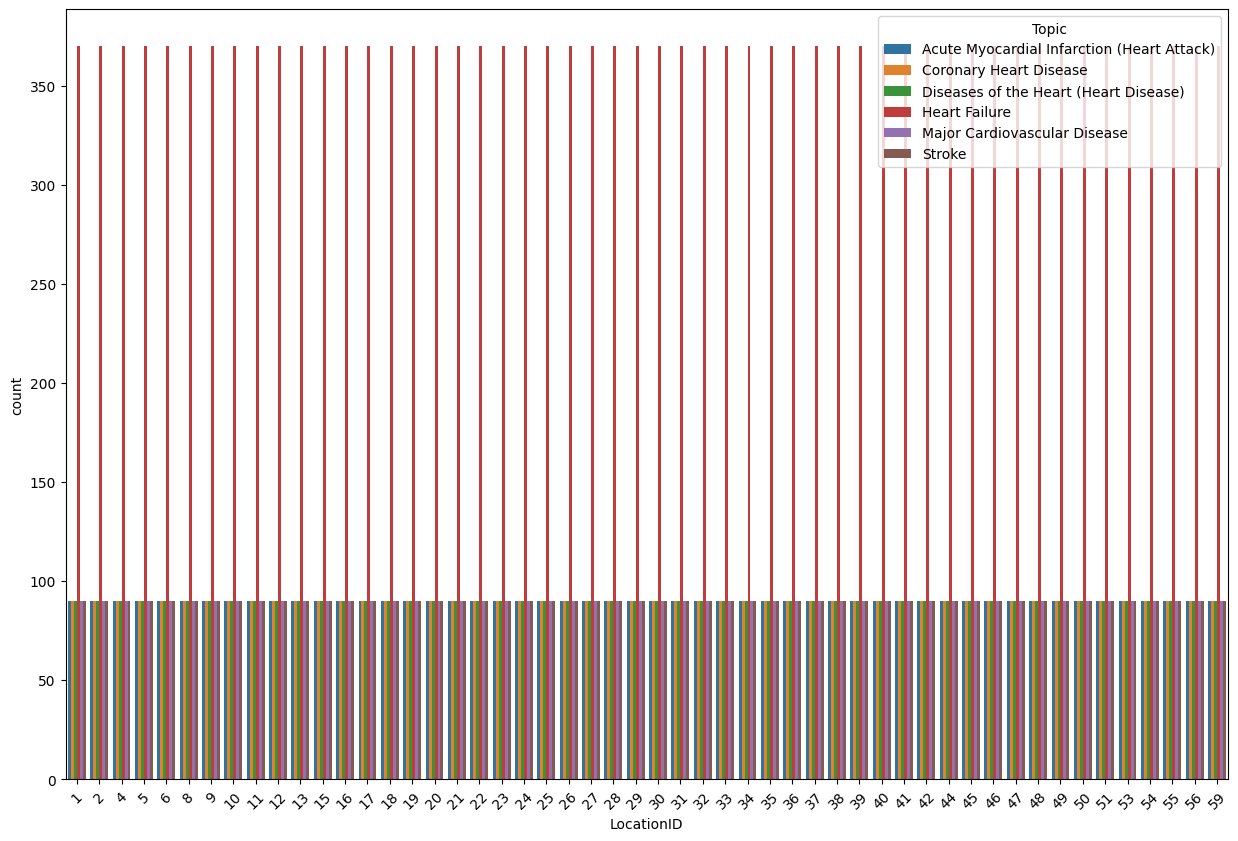

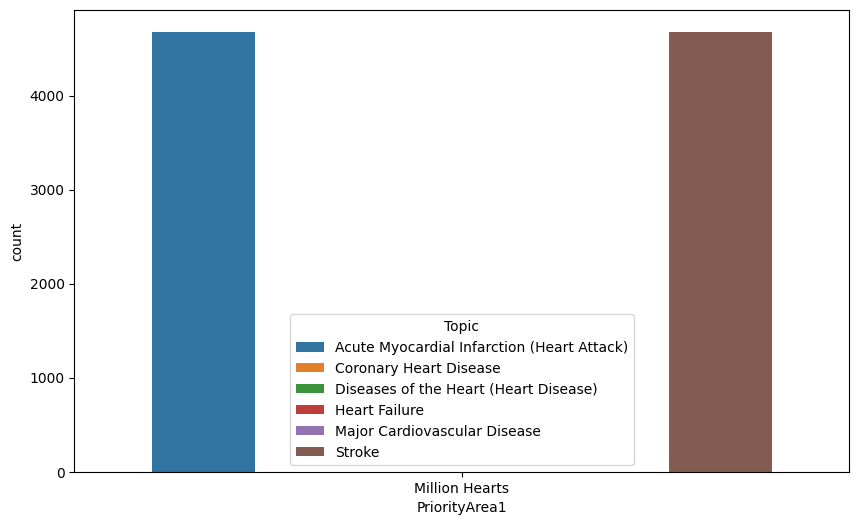

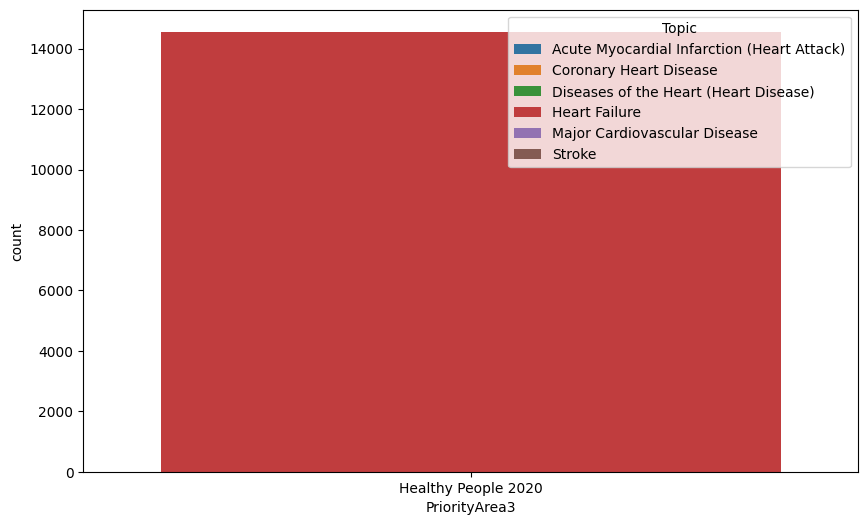

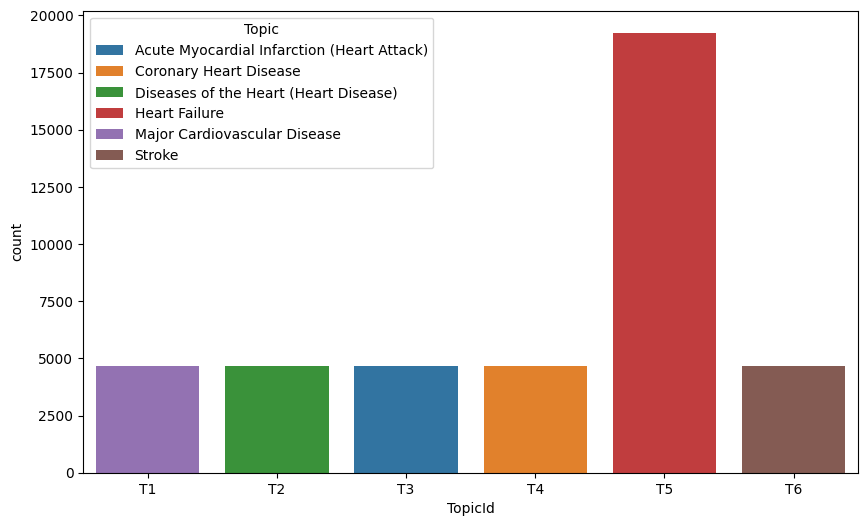

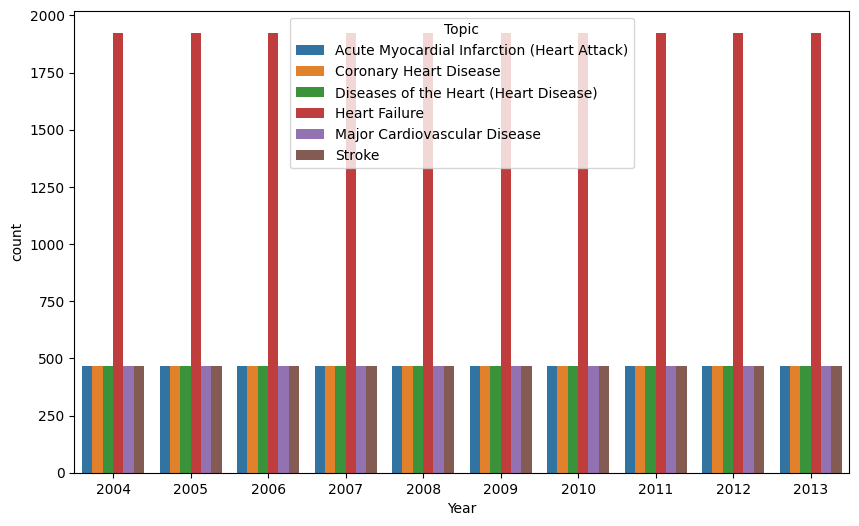

In [174]:
import seaborn as sb
import matplotlib.pyplot as plt

for attribute in categoricalAttributes:
    if attribute in ['GeoLocation', 'Indicator', 'IndicatorID', 'LocationAbbr', 'LocationDesc', 'LocationID']:
        plt.figure(figsize=(15, 10))
        plot = sb.countplot(x=attribute, hue='Topic', data=df)
        plt.xticks(rotation=45)
    else:
        plt.figure(figsize=(10, 6))
        plot = sb.countplot(x=attribute, hue='Topic', data=df)
    plt.show()

##### **Box plot (numerical attributes)**

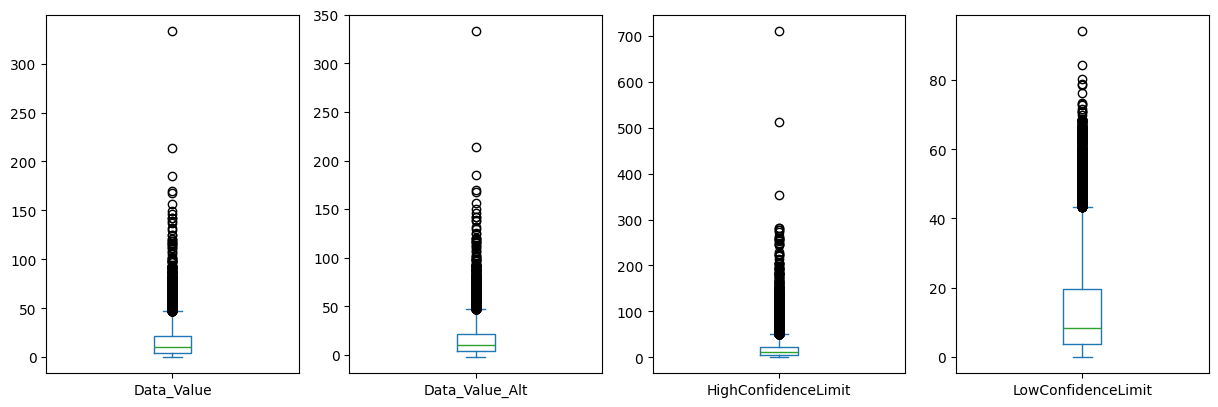

In [175]:
numericDF.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(15, 27), layout=(5, 4))
plt.show()

##### **pairplot (numerical attributes)**

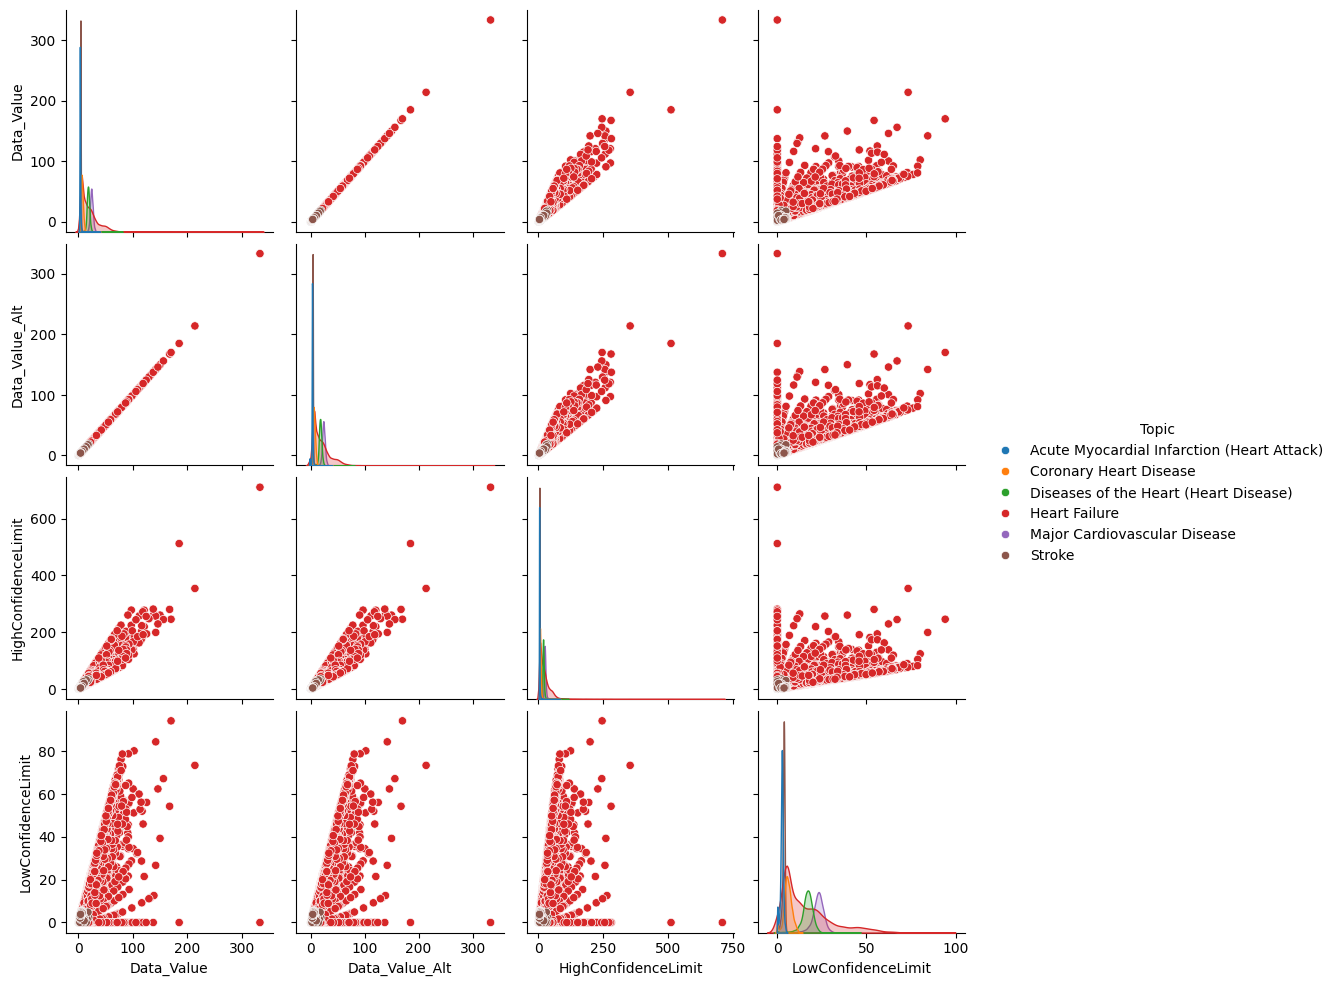

In [176]:
sb.pairplot(df, hue = 'Topic')
plt.show()

### **correlation matrix**

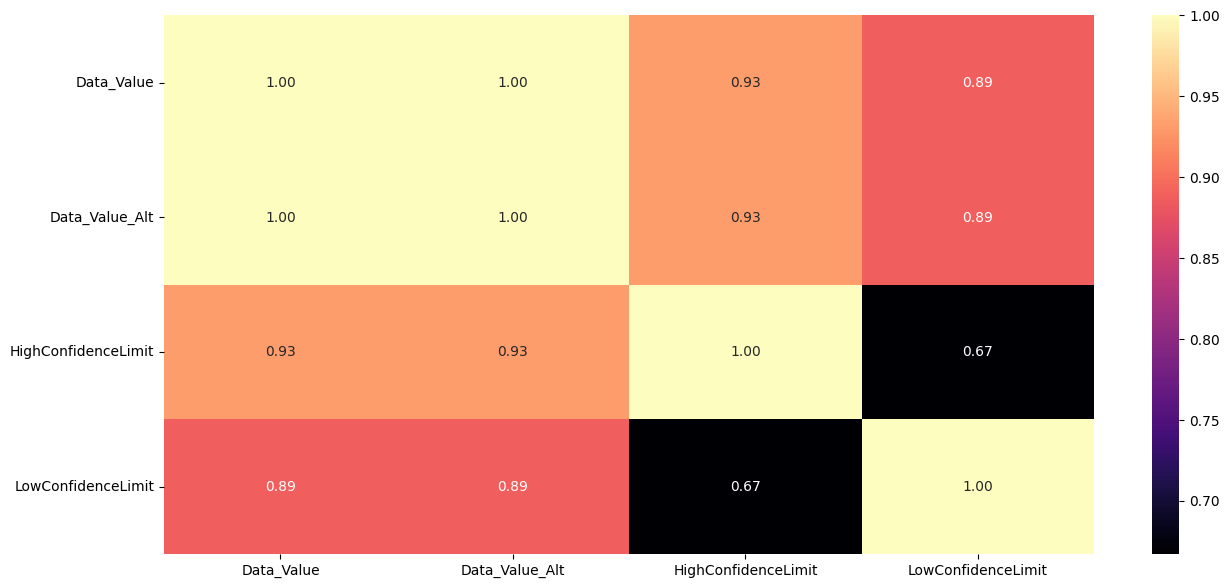

In [177]:
plt.figure(figsize=(15, 7))
sb.heatmap(numericDF.corr(), annot=True, cmap='magma', fmt='.2f')
plt.show()

### **Data Preparation**

From the Heat map(correlation Matrix) above we can understand that Data_Value have the maximum correlation with Data_Value_Al, LowConfidenceLimit and HighConfidenceLimit
There for we can drop Data_Value attribute.

In [178]:
df = df.drop(columns=['Data_Value'])

#### ***To Drop irrelevant Features***

#### **Get unique value count for each attribute**

In [179]:
df.nunique()

BreakOutCategoryId               4
BreakOutId                       9
Break_Out                        9
Break_Out_Category               4
Category                         1
CategoryId                       1
DataSource                       1
Data_Value_Alt                 814
Data_Value_Footnote              1
Data_Value_Footnote_Symbol       1
Data_Value_Type                  1
Data_Value_TypeID                1
Data_Value_Unit                  2
GeoLocation                     51
HighConfidenceLimit           1059
Indicator                       10
IndicatorID                     10
LocationAbbr                    52
LocationDesc                    52
LocationID                      52
LowConfidenceLimit             680
PriorityArea1                    1
PriorityArea3                    1
Topic                            6
TopicId                          6
Year                            10
dtype: int64

##### *Remove all the attributes with too high (typically IDs) or too low variability (column that exhibit the same value for all the records) and all redundat attribute*

In [180]:
## low variability
df = df.drop(columns=[col for col in df.columns if df[col].nunique() < 2])

In [181]:
## drop the 'Indicator' attribute and typically IDs
df = df[df.columns.difference(
    ['Indicator', 'IndicatorID', 'BreakOutCategoryId', 'BreakOutId', 'TopicId'])]

##### **comparing location attribute**

In [182]:
compare_location = pd.DataFrame({'LocationAbbr': df.LocationAbbr, 'LocationDesc': df.LocationDesc, 'GeoLocation': df.GeoLocation, 'LocationID': df.LocationID})
compare_location.value_counts()

LocationAbbr  LocationDesc    GeoLocation                                LocationID
AK            Alaska          (64.84507995700051, -147.72205903599973)   2             820
PA            Pennsylvania    (40.79373015200048, -77.86070029399963)    42            820
ND            North Dakota    (47.47531977900047, -100.11842104899966)   38            820
NE            Nebraska        (41.6410409880005, -99.36572062299967)     31            820
NH            New Hampshire   (43.65595011300047, -71.50036091999965)    33            820
NJ            New Jersey      (40.13057004800049, -74.27369128799967)    34            820
NM            New Mexico      (34.52088095200048, -106.24058098499967)   35            820
NV            Nevada          (39.493240390000494, -117.07184056399967)  32            820
NY            New York        (42.82700103200045, -75.54397042699964)    36            820
OH            Ohio            (40.06021014100048, -82.40426005599966)    39            820
OK    

##### From above we can observe that **LocationAbbr** is the abbrevation of **LocationDesc**, **GeoLocation** is the magnitude and longitude representation of location and **LocationID** is the ID for LocationDes
##### We can drop these columns as they are redundant

In [183]:
## LocationAbbr is the abbrevation of LocationDesc.
df = df[df.columns.difference(
    ['GeoLocation', 'LocationID', 'LocationDesc'])]

##### *Highlight missing values*

In [184]:
df.isnull().sum()

Break_Out                0
Break_Out_Category       0
Data_Value_Alt           0
Data_Value_Unit          0
HighConfidenceLimit    529
LocationAbbr             0
LowConfidenceLimit     529
Topic                    0
Year                     0
dtype: int64

<Axes: >

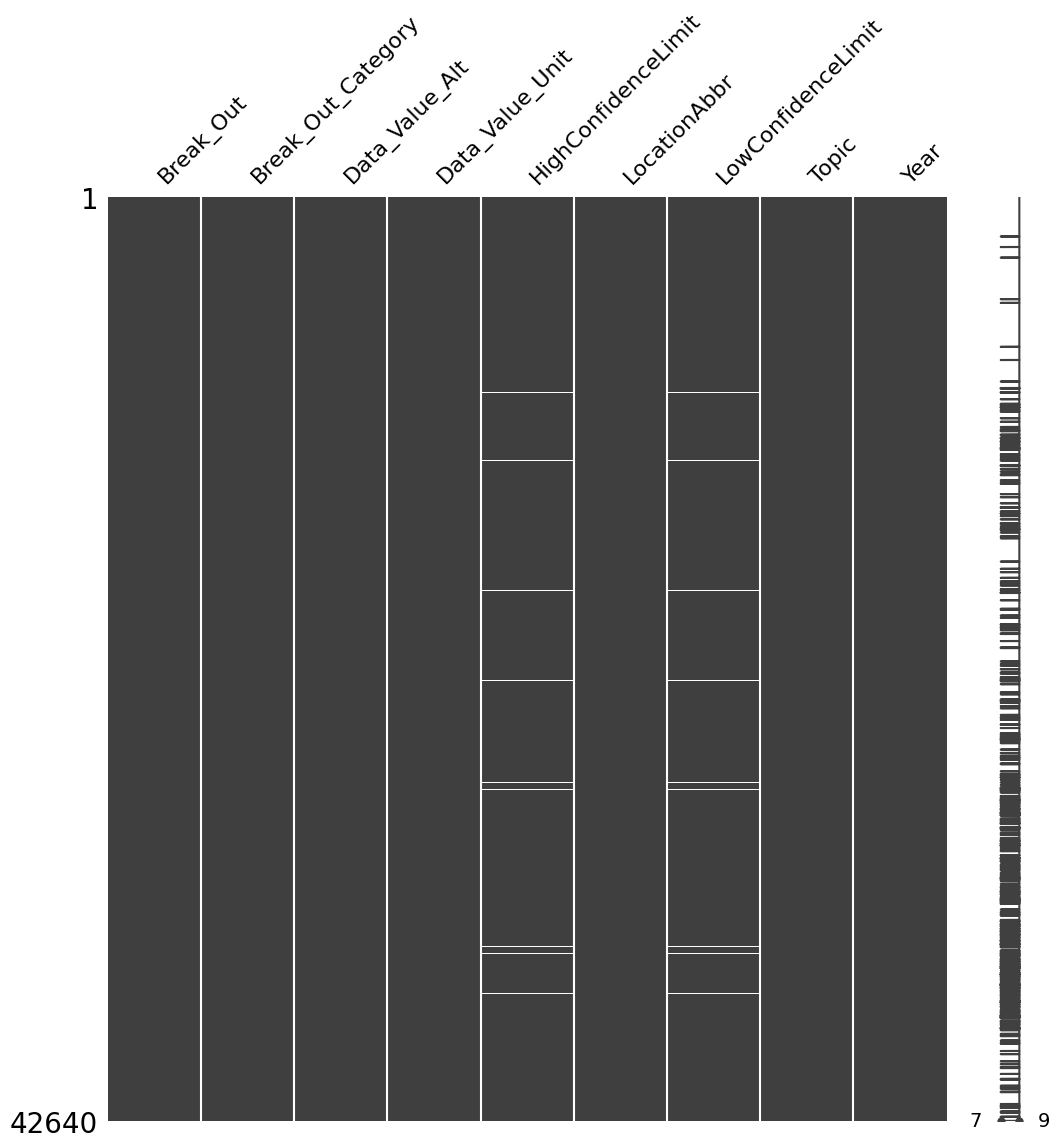

In [185]:
msno.matrix(df,figsize=(12,12))

In [186]:
df["HighConfidenceLimit"] = df["HighConfidenceLimit"].fillna(df["HighConfidenceLimit"].median())
df["LowConfidenceLimit"] = df["LowConfidenceLimit"].fillna(df["LowConfidenceLimit"].median())

In [187]:
df.isnull().sum()

Break_Out              0
Break_Out_Category     0
Data_Value_Alt         0
Data_Value_Unit        0
HighConfidenceLimit    0
LocationAbbr           0
LowConfidenceLimit     0
Topic                  0
Year                   0
dtype: int64

In [188]:
print(len(df[df.duplicated()]))

176


In [189]:
df=df.drop_duplicates()

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42464 entries, 0 to 42639
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Break_Out            42464 non-null  category
 1   Break_Out_Category   42464 non-null  category
 2   Data_Value_Alt       42464 non-null  float64 
 3   Data_Value_Unit      42464 non-null  category
 4   HighConfidenceLimit  42464 non-null  float64 
 5   LocationAbbr         42464 non-null  category
 6   LowConfidenceLimit   42464 non-null  float64 
 7   Topic                42464 non-null  category
 8   Year                 42464 non-null  category
dtypes: category(6), float64(3)
memory usage: 1.5 MB


##### **Avoiding contradictory examples in the data set**

In [191]:
duplicates = df.duplicated(subset=['Break_Out', 'Break_Out_Category','Data_Value_Alt', 'Data_Value_Unit', 'HighConfidenceLimit', 'LocationAbbr', 'LowConfidenceLimit', 'Year'], keep=False)
p= duplicates.sum()
print(p)

826


In [192]:
df = df[~duplicates]

In [193]:
df.shape

(41638, 9)

In [194]:
df.to_excel('finaldata1.xlsx', index=False)